## Objective
Determine how consistent kilosort's latencies and relative amplitudes are in individual spikes
- 230724_kilosort_latencies_and_rel_amp

## General setup

In [1]:
%load_ext autoreload

In [2]:
from multiprocessing import Pool

import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm

%autoreload 2
from src.sorters.kilosort import get_experts_kilosort
from src import utils, plot

In [3]:
KILOSORT = get_experts_kilosort(freq_max=3000)

/home/mea/anaconda3/envs/prop/lib/python3.7/site-packages/hdmf/spec/namespace.py:456: UserWarning: ignoring namespace 'hdmf-common' because it already exists
  warn("ignoring namespace '%s' because it already exists" % ns['name'])
/home/mea/anaconda3/envs/prop/lib/python3.7/site-packages/hdmf/spec/namespace.py:456: UserWarning: ignoring namespace 'core' because it already exists
  warn("ignoring namespace '%s' because it already exists" % ns['name'])
/data/MEAprojects/PropSignal/src/comparison.py:336: UserWarning: Using Comparison.count_matching_events_si which is inaccurate when many spikes in succession match between the two sorters
  warnings.warn("Using Comparison.count_matching_events_si which is inaccurate when many spikes in succession match between the two sorters", UserWarning)
/data/MEAprojects/PropSignal/src/sorters/kilosort.py:154: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with differ

Recording does not have scaled traces. Setting gain to 0.195


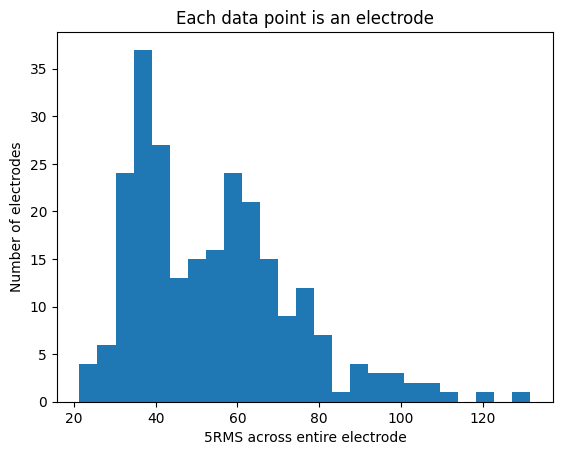

In [4]:
CHANS_RMS = utils.chans_rms_si()
RMS_THRESH = 5
##
plt.hist(CHANS_RMS * RMS_THRESH, bins=25)

plt.title("Each data point is an electrode")
plt.xlabel(f"{RMS_THRESH}RMS across entire electrode")
plt.ylabel("Number of electrodes")
plt.show()

In [10]:
# Find number of kilosort spikes across all units within X_MS of each other
X_MS = 0.1

all_spike_trains = []
for spike_train in KILOSORT.get_spike_times():
    all_spike_trains.extend(spike_train)
all_spike_trains = np.sort(all_spike_trains)

count = 0
for i in range(1, len(all_spike_trains)):
    if all_spike_trains[i] - all_spike_trains[i-1] <= X_MS:
        count += 1

print(f"#overlaps: {count}")
print(f"#overlaps/total: {count / len(all_spike_trains) * 100:.1f}%")

#overlaps: 173594
#overlaps/total: 14.9%


In [5]:
ks_units = [unit for unit in KILOSORT]

### Specific example case of templates
For finding good electrode to develop RT-Sort

In [4]:
ks_units = []
for unit in KILOSORT:
    unit.spike_train = unit.spike_train[unit.spike_train <= 5*60*1000]
    ks_units.append(unit)

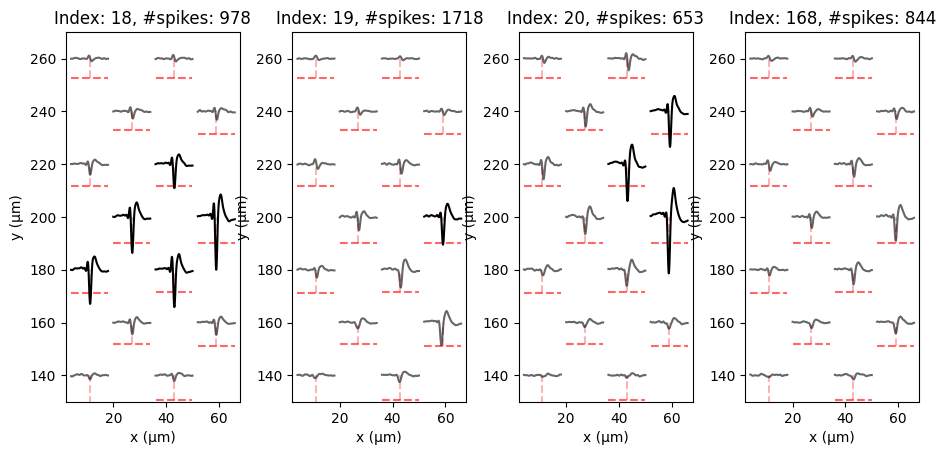

In [17]:
units = chan_to_ks_unit[17]
kwargs = None
fig, axes = plt.subplots(ncols=len(units), figsize=(2.8*len(units), 4.8))
axes = np.atleast_1d(axes)
for i, unit in enumerate(units):
    if kwargs is None:
        kwargs = unit.plot(chans_rms=CHANS_RMS, axis=axes[i])
    else:
        unit.plot(**kwargs, axis=axes[i])
plt.show()

## Extract unit templates

In [5]:
NUM_WFS = 300
MS_BEFORE = 2
MS_AFTER = 2

np.random.seed(231)
##
def extract_templates(unit_idx):
    unit = ks_units[unit_idx]
    return unit_idx, unit.get_templates(num_wfs=NUM_WFS, ms_before=MS_BEFORE, ms_after=MS_AFTER)

with Pool(processes=12) as pool:
    for unit_idx, templates in tqdm(pool.imap(extract_templates, range(len(ks_units))), total=len(ks_units)):
        ks_units[unit_idx].templates = templates

100%|██████████| 226/226 [01:13<00:00,  3.09it/s]


In [8]:
chan_to_ks_unit = {}
for unit in ks_units:
    unit.chan = np.argmin(np.min(unit.templates, axis=1))
    if unit.chan not in chan_to_ks_unit:
        chan_to_ks_unit[unit.chan] = [unit]
    else:
        chan_to_ks_unit[unit.chan].append(unit)

0


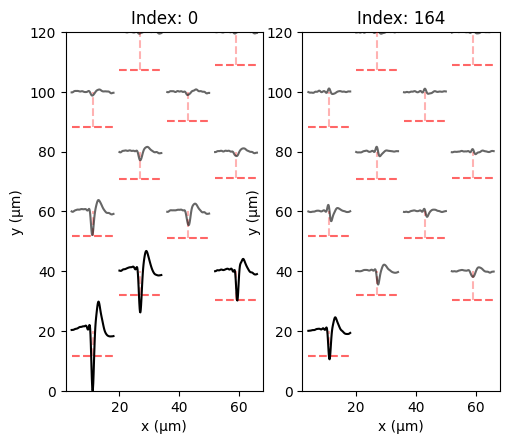

1


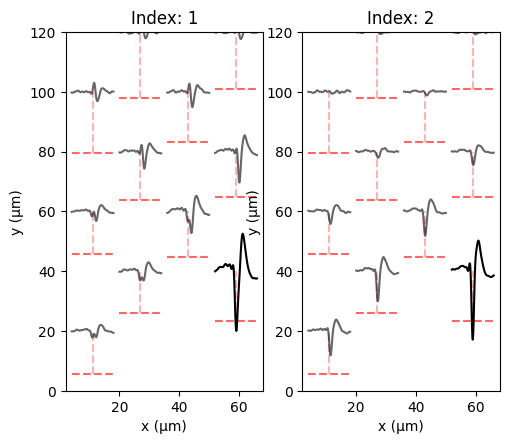

3


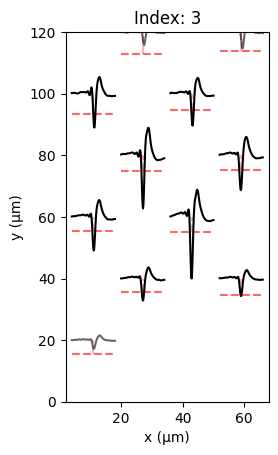

5


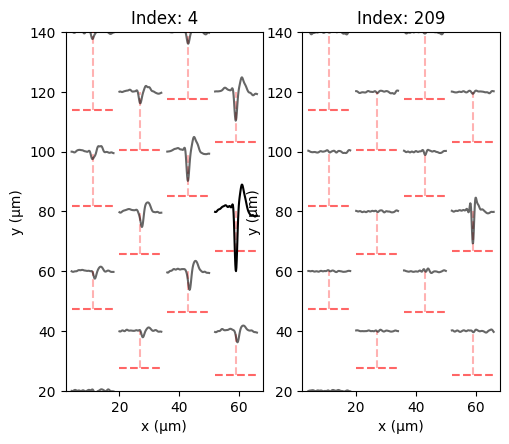

7


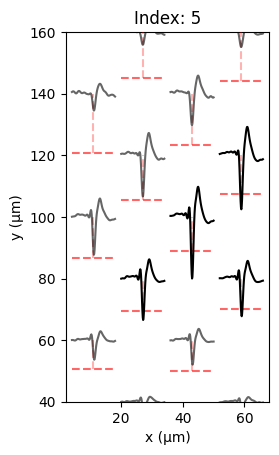

8


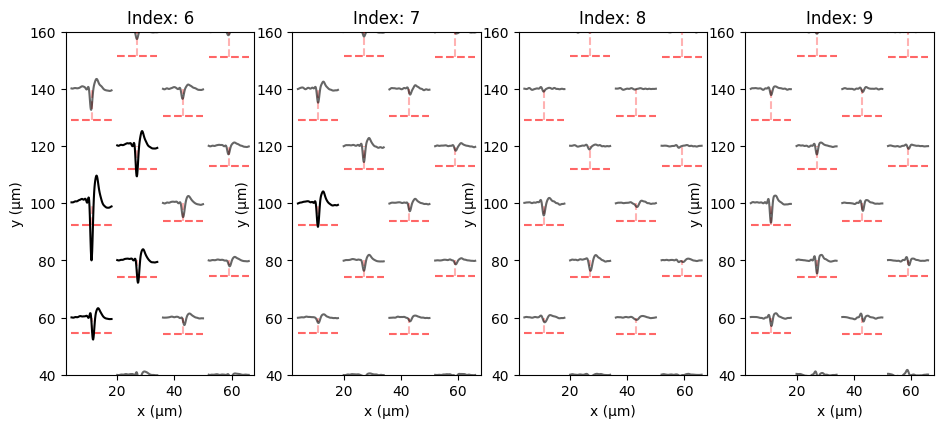

9


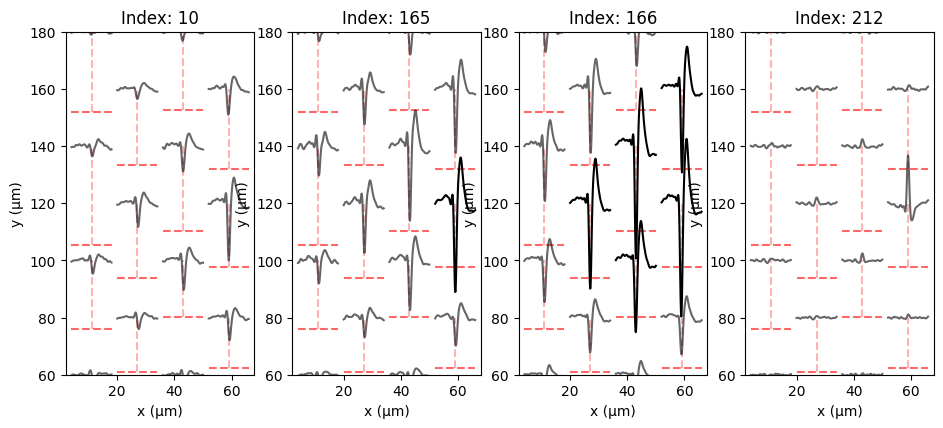

10


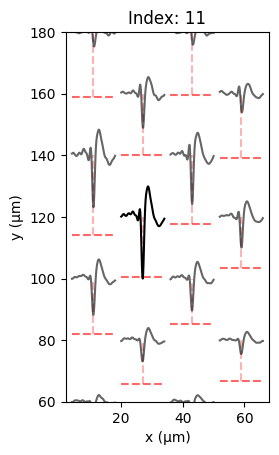

12


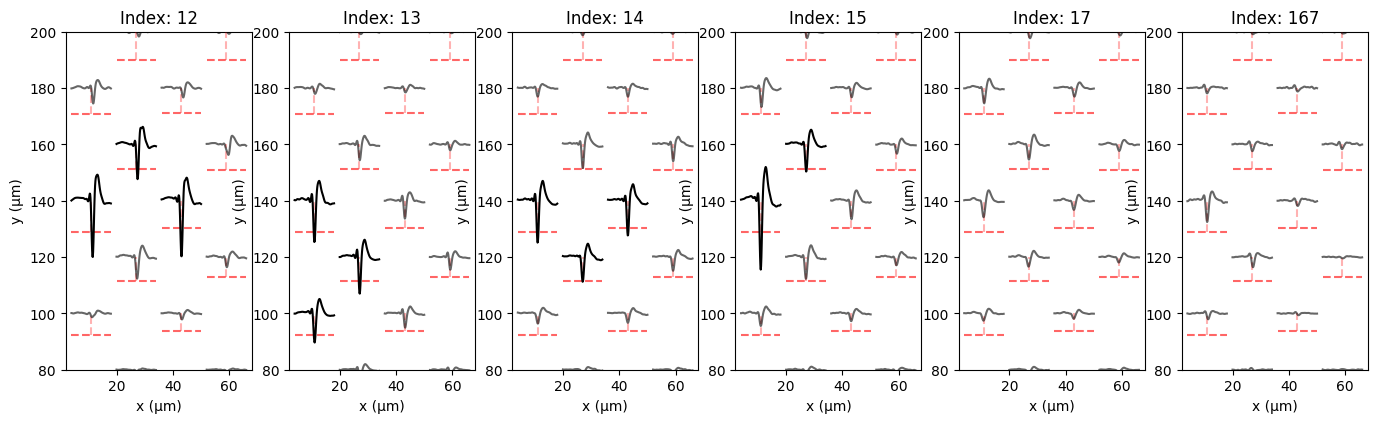

13


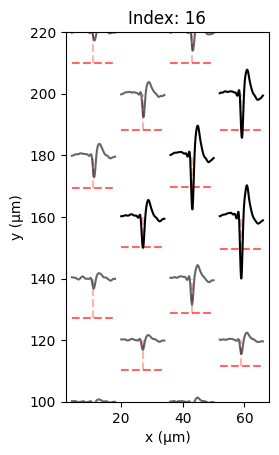

17


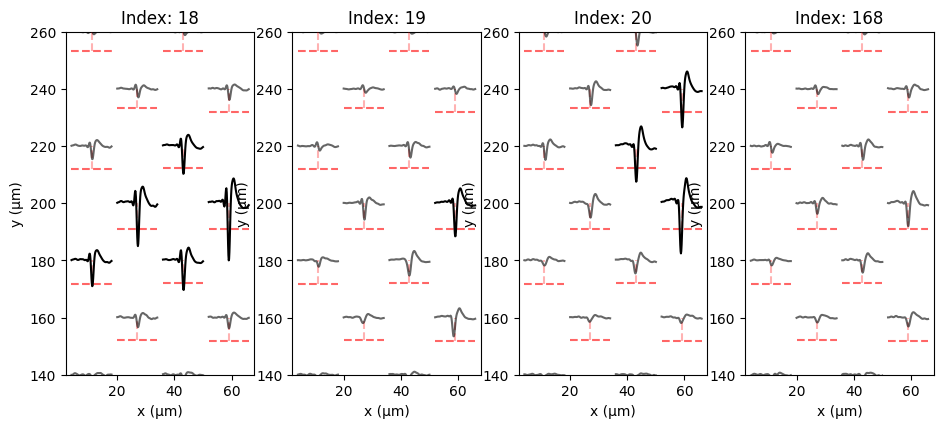

18


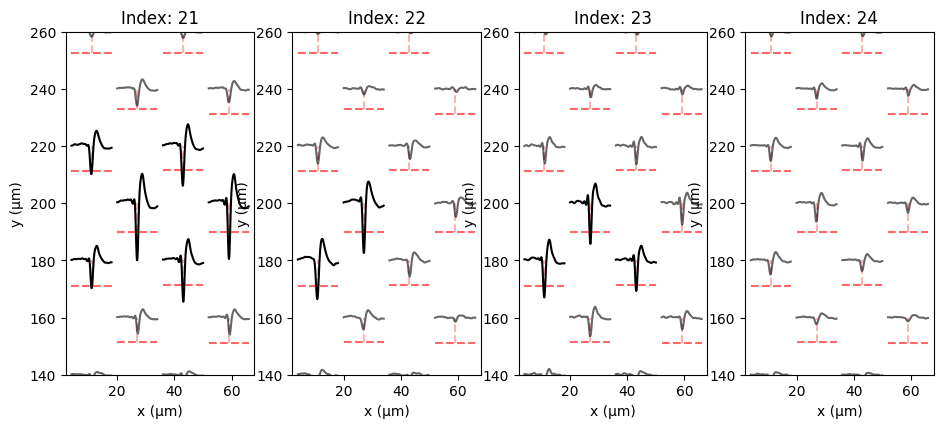

20


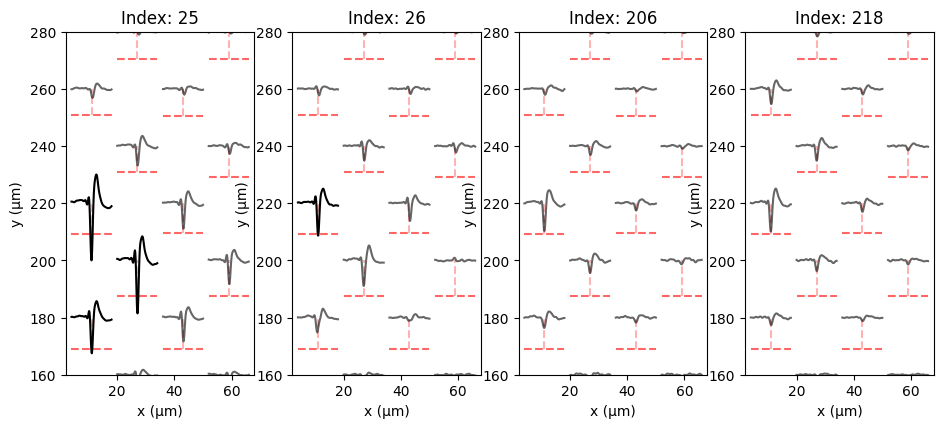

21


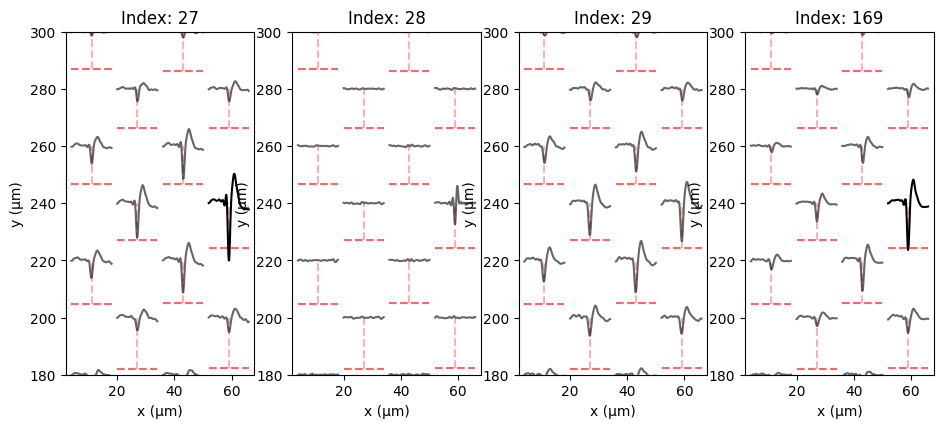

24


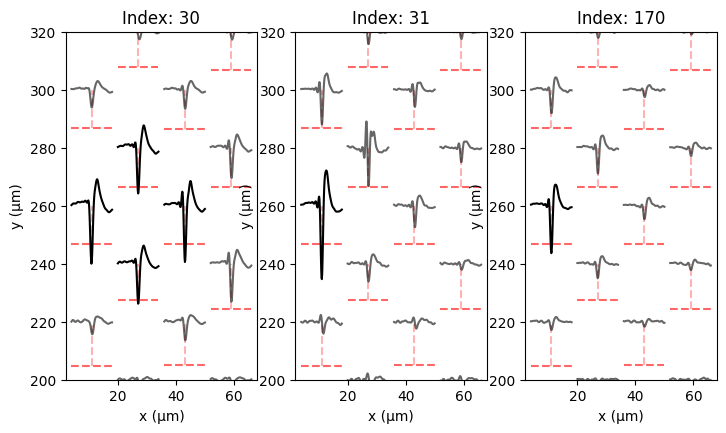

23


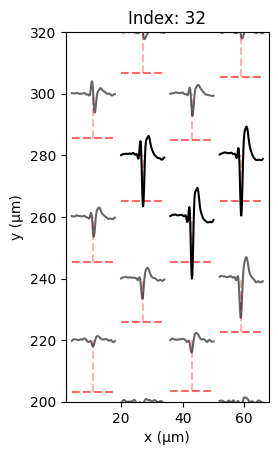

25


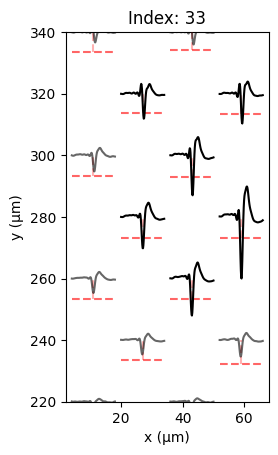

27


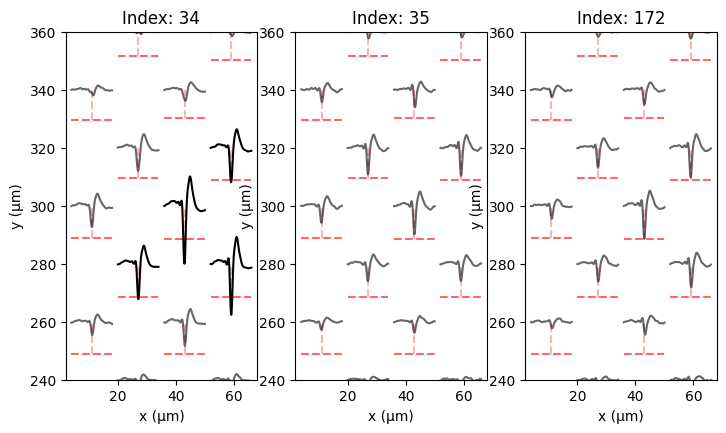

28


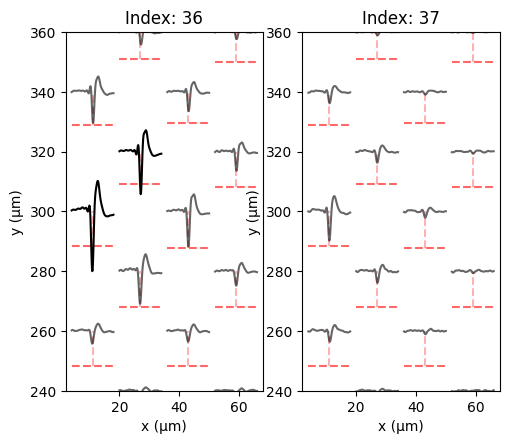

29


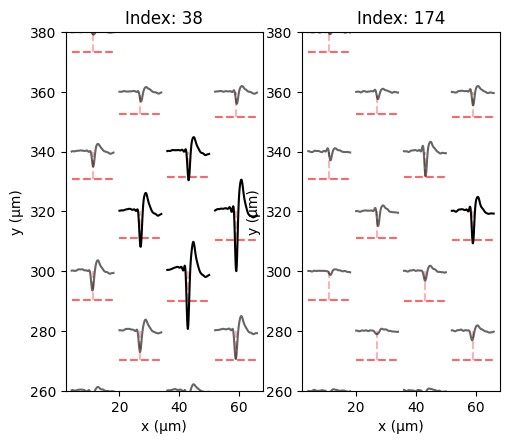

31


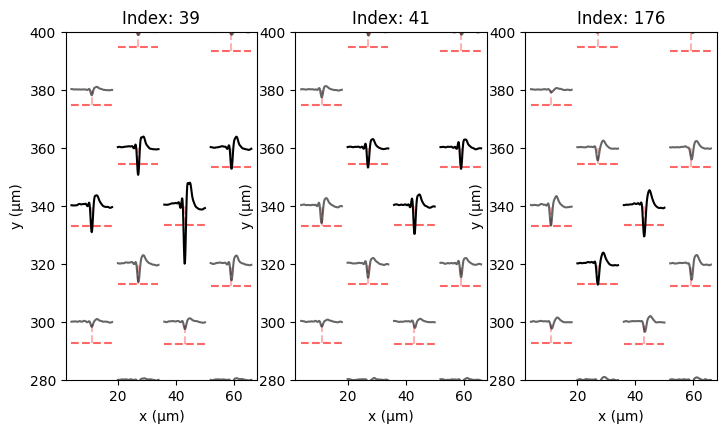

30


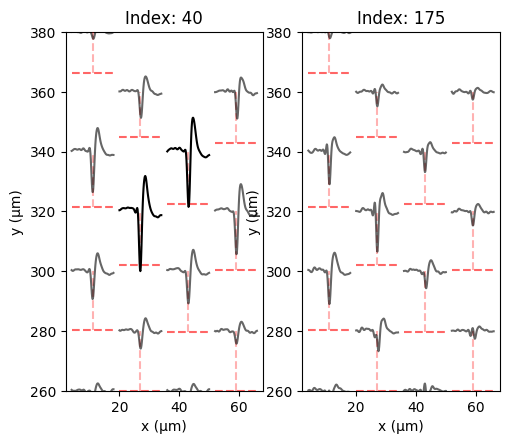

32


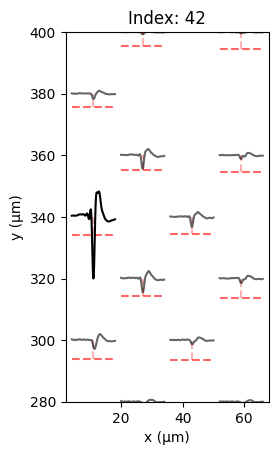

34


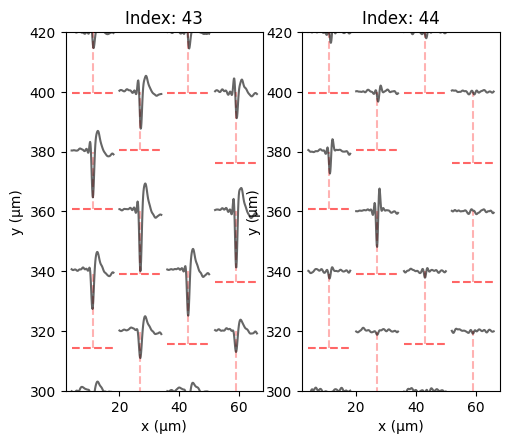

36


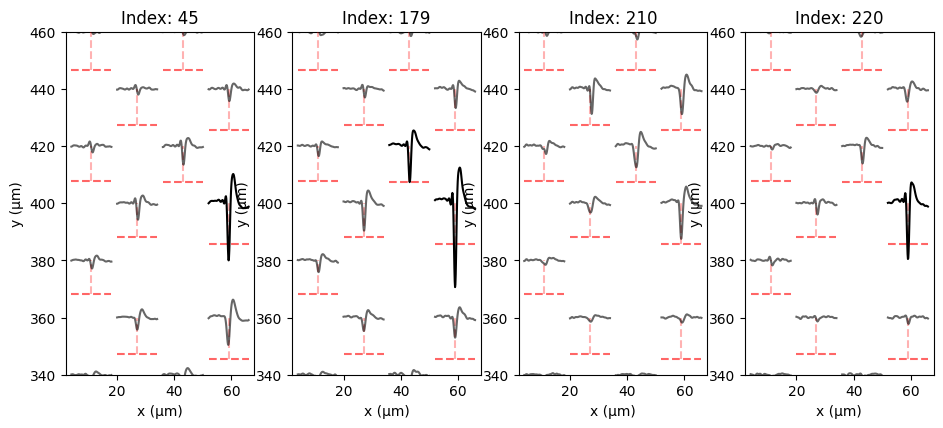

38


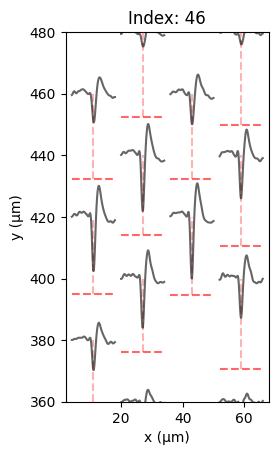

39


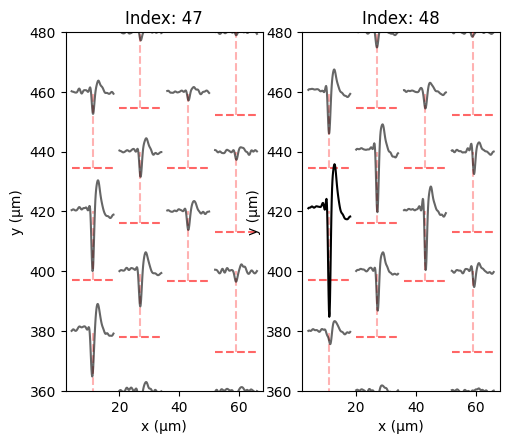

40


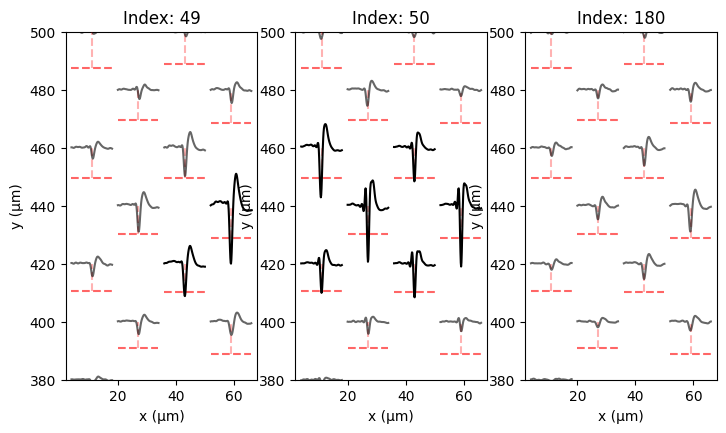

42


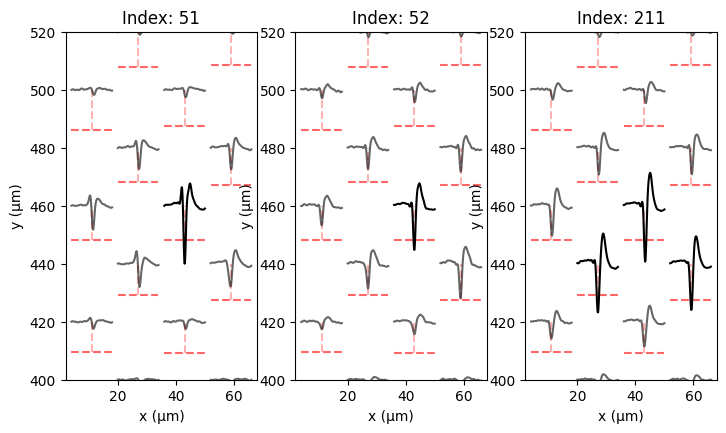

43


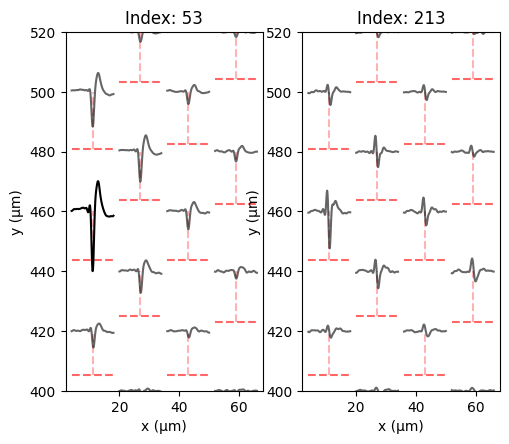

44


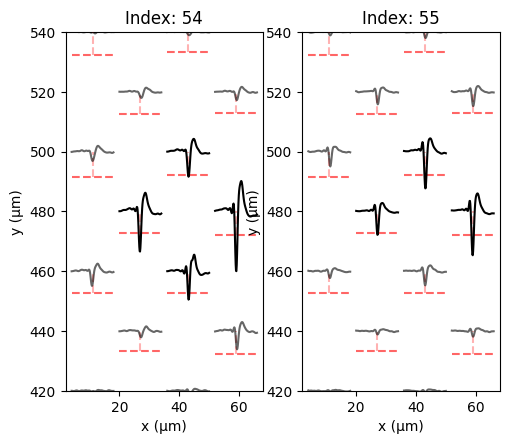

47


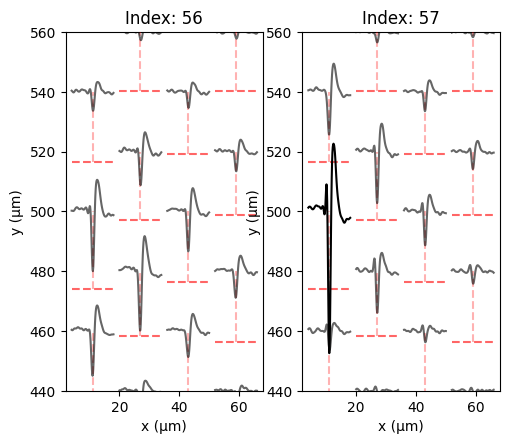

48


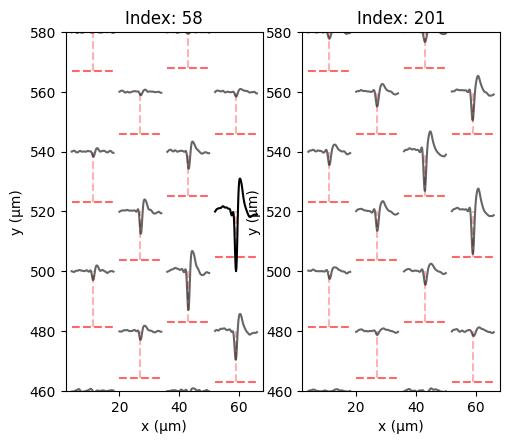

49


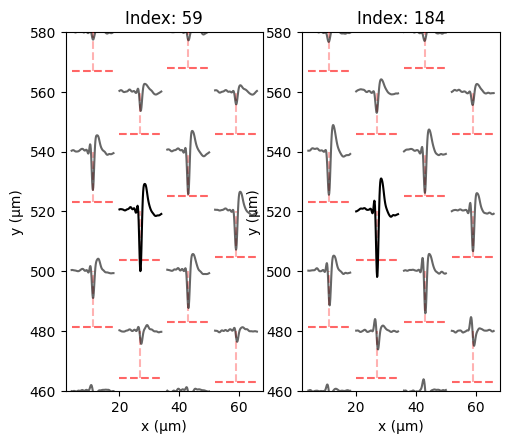

51


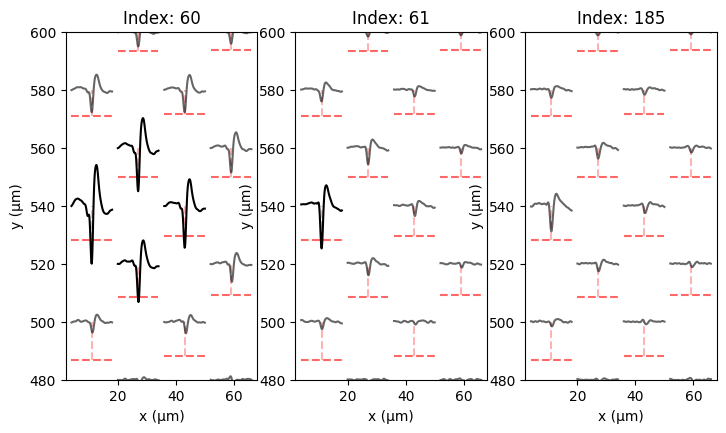

52


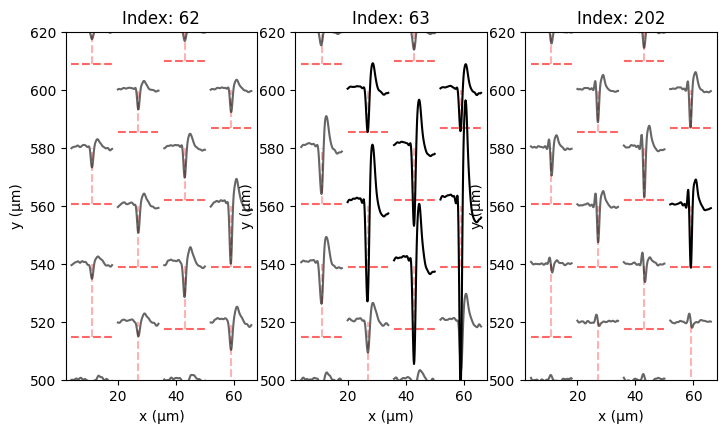

53


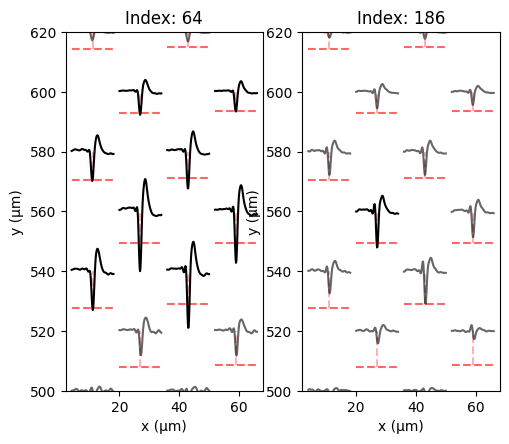

55


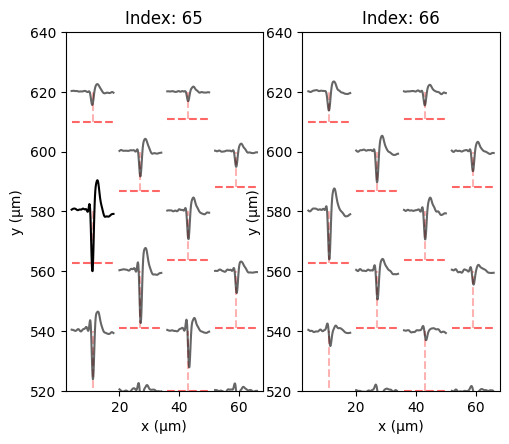

57


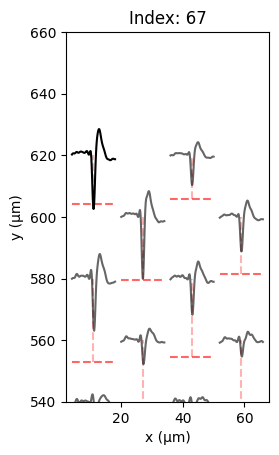

61


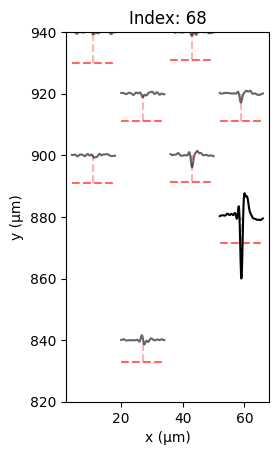

73


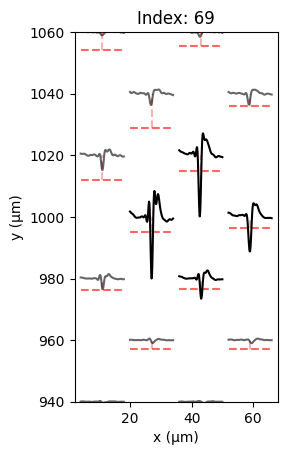

75


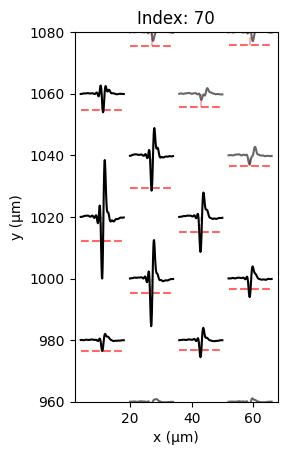

77


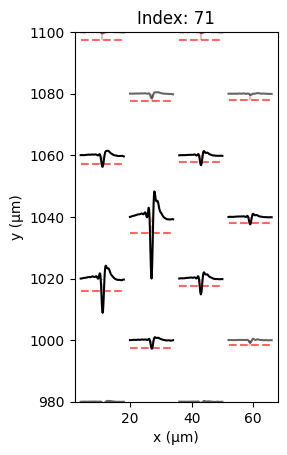

79


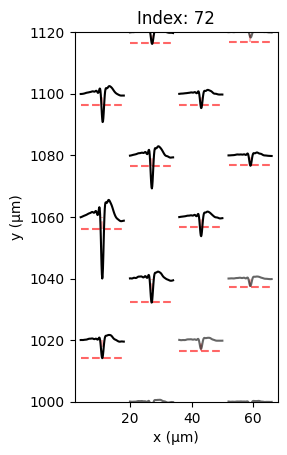

80


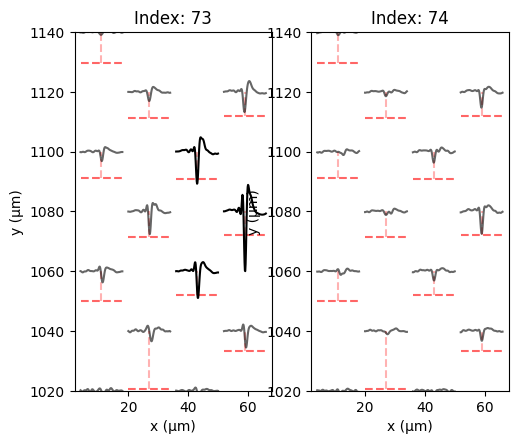

83


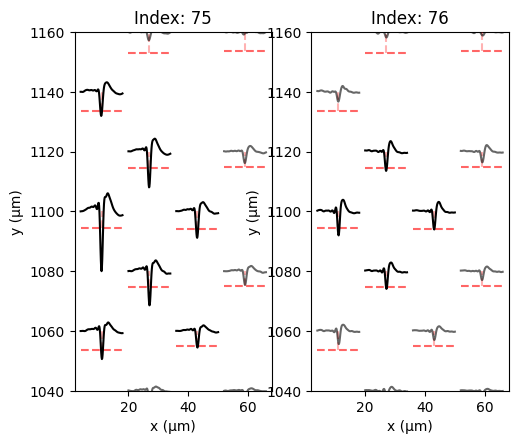

84


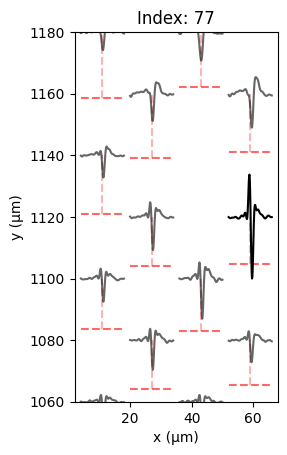

90


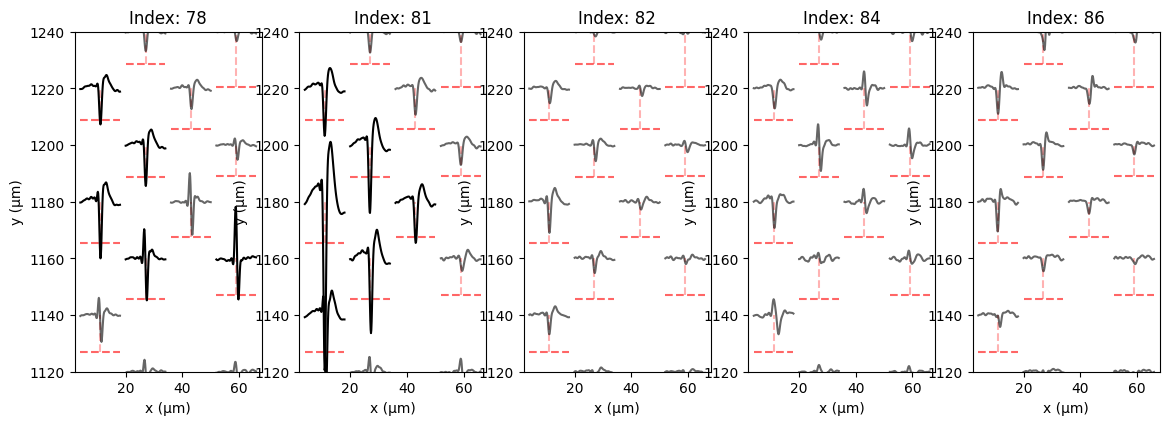

87


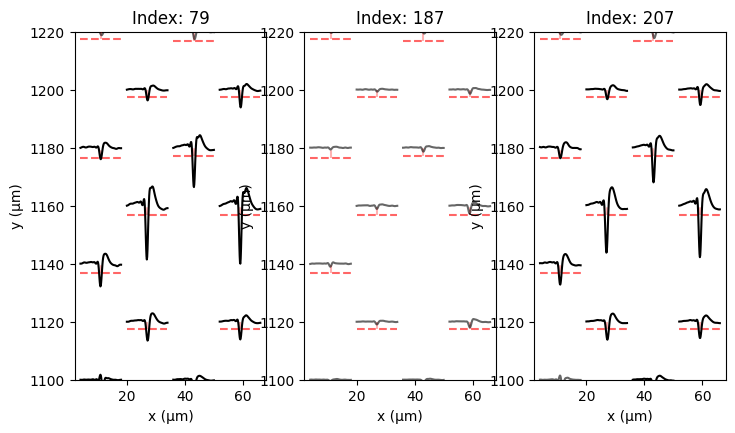

89


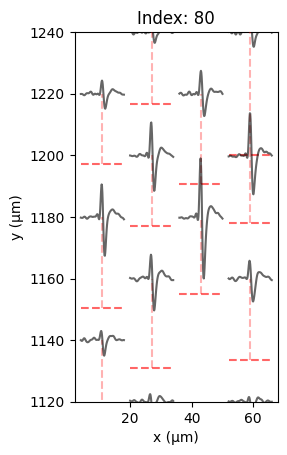

92


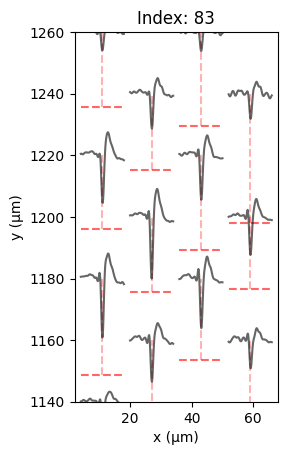

97


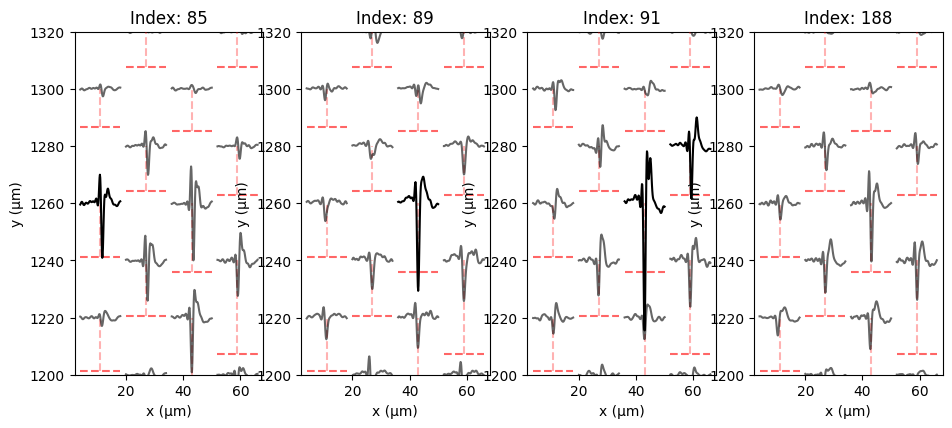

95


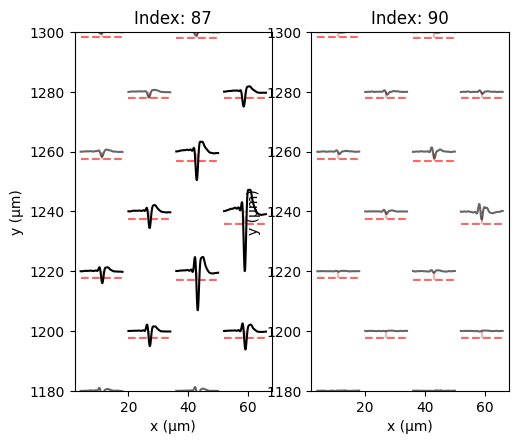

96


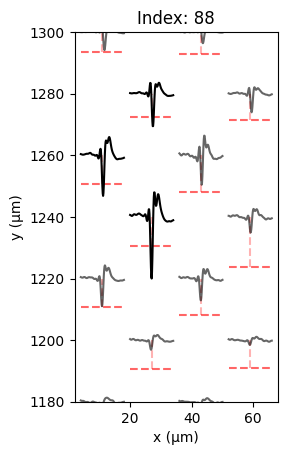

98


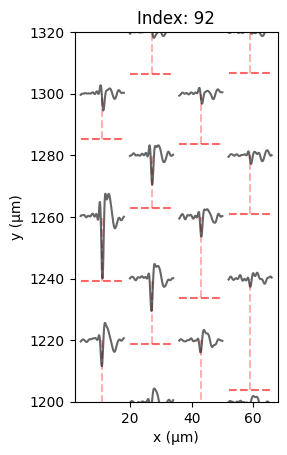

118


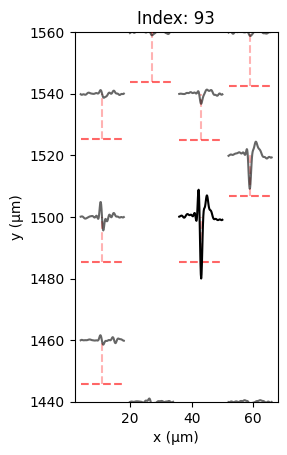

124


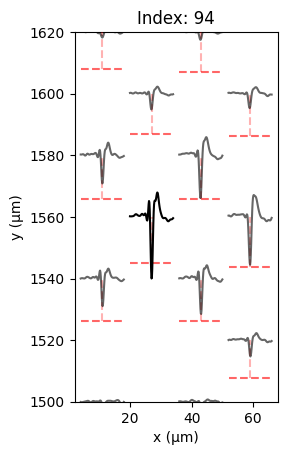

133


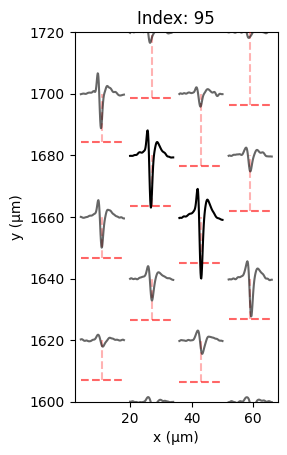

145


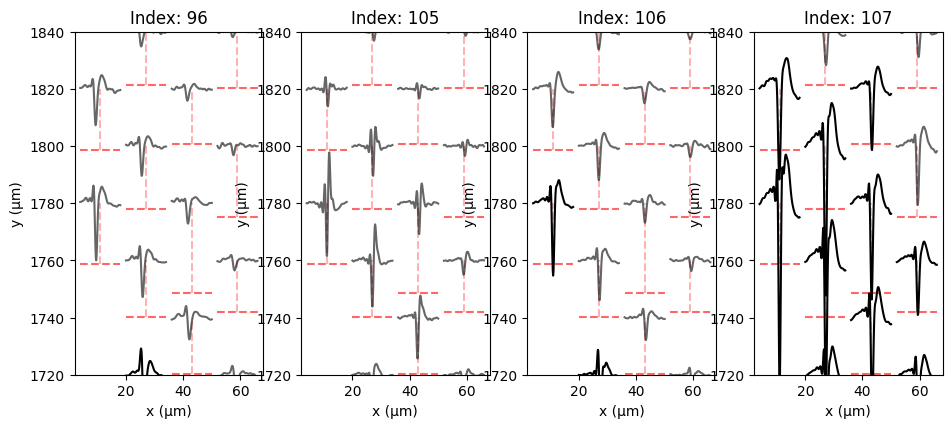

136


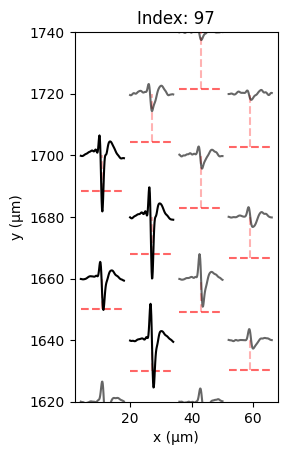

140


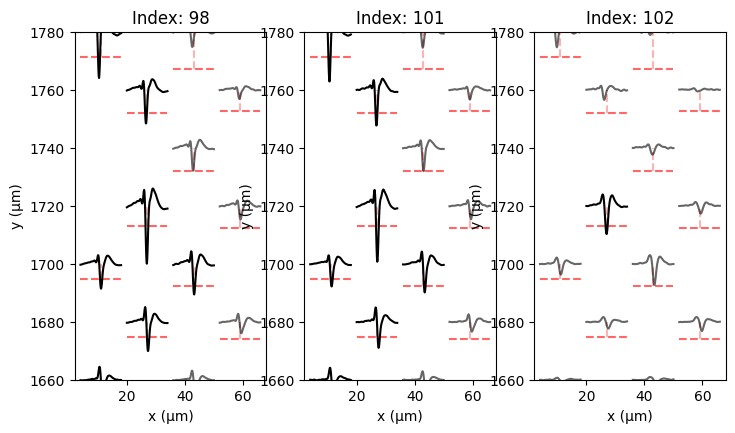

138


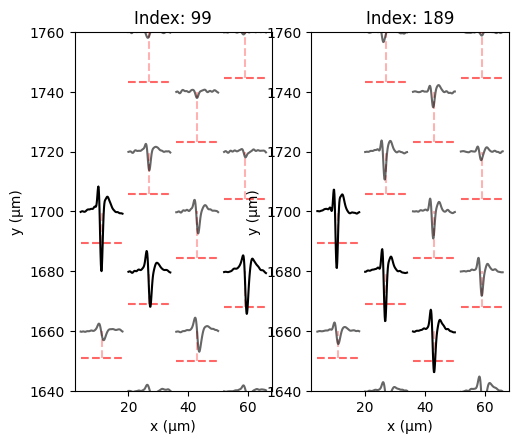

144


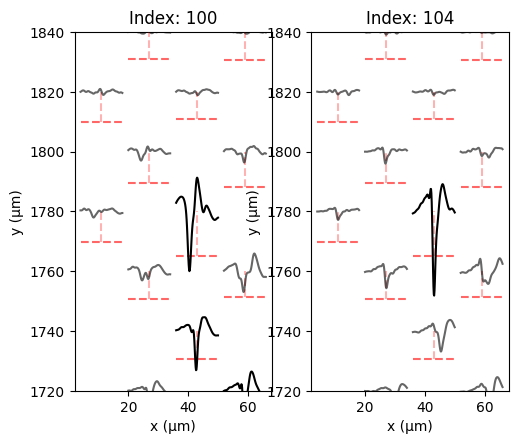

142


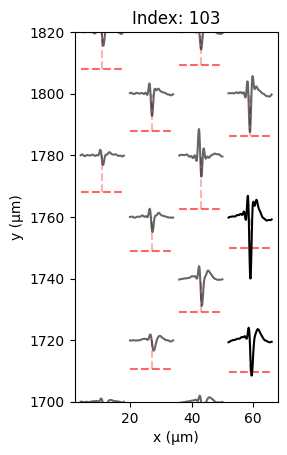

146


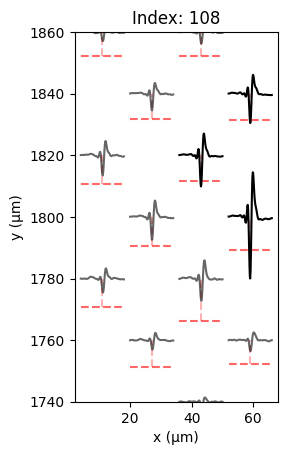

147


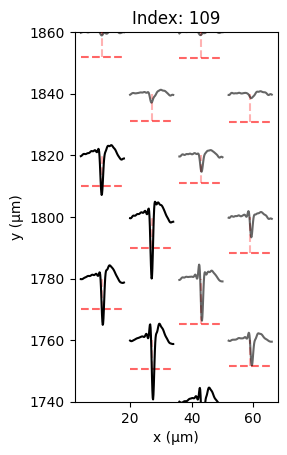

149


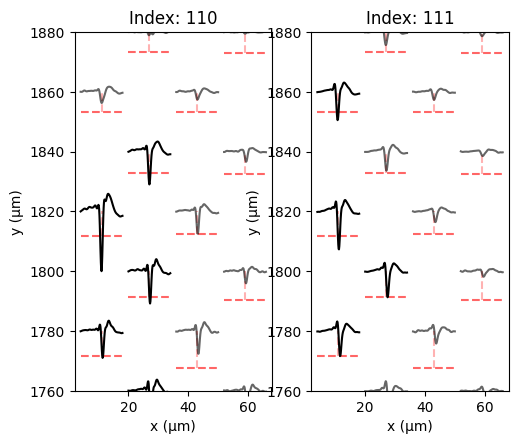

150


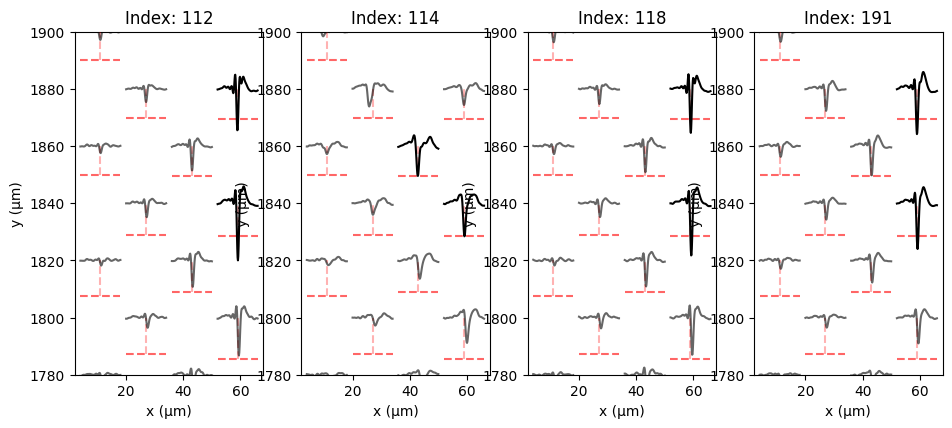

151


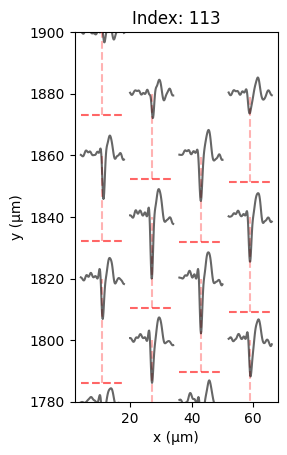

153


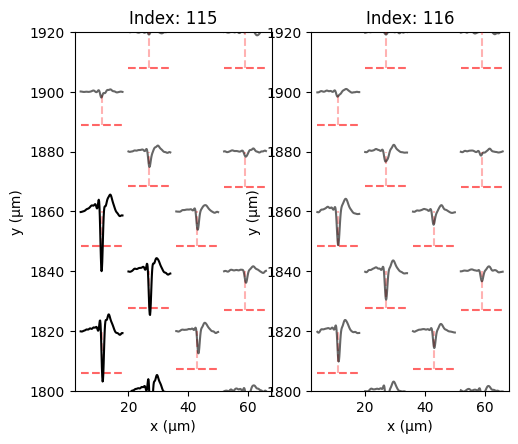

154


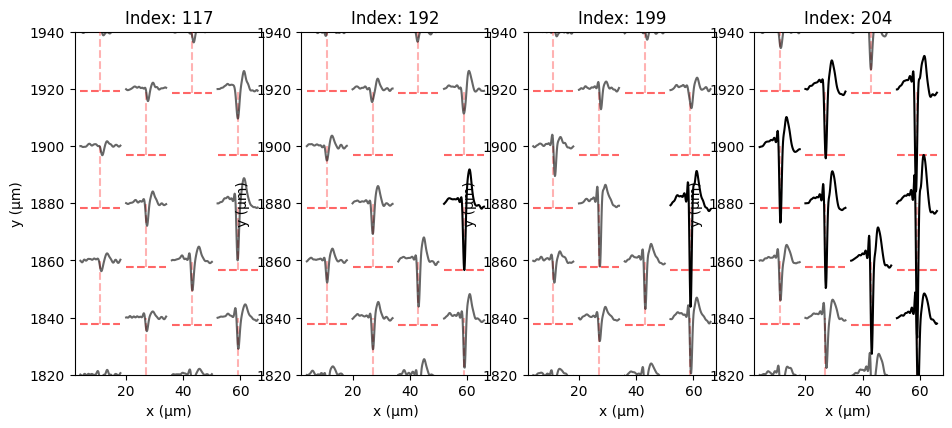

155


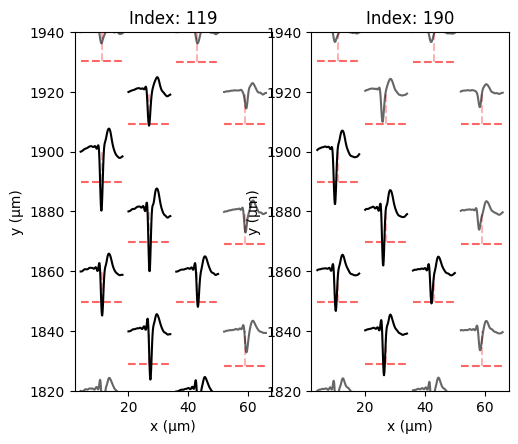

156


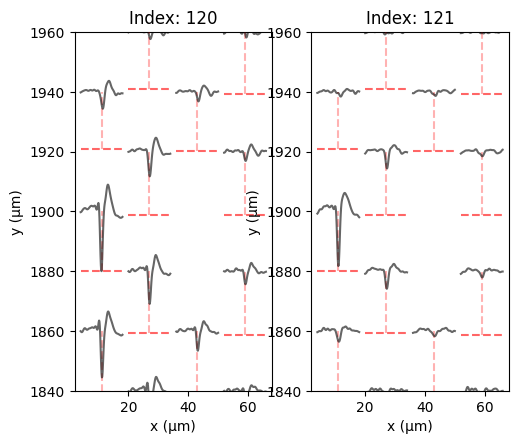

157


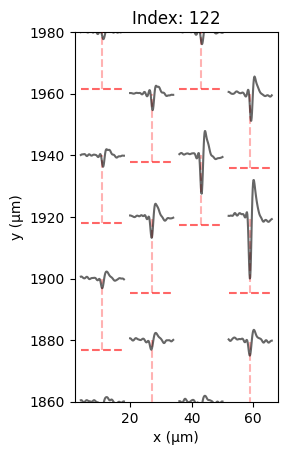

158


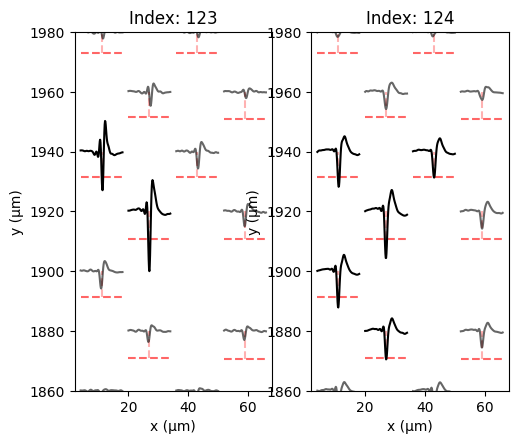

161


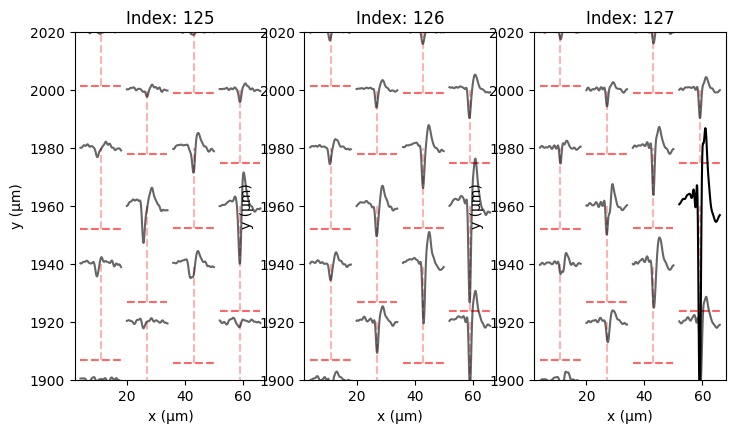

162


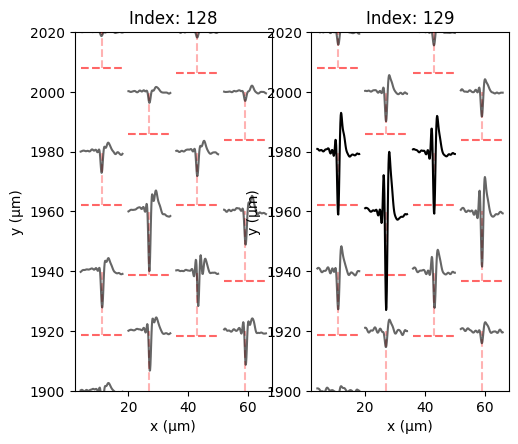

164


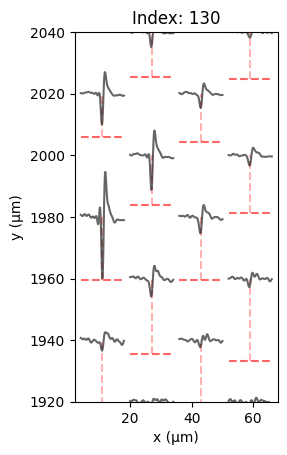

165


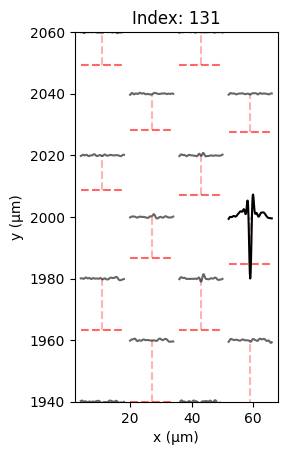

186


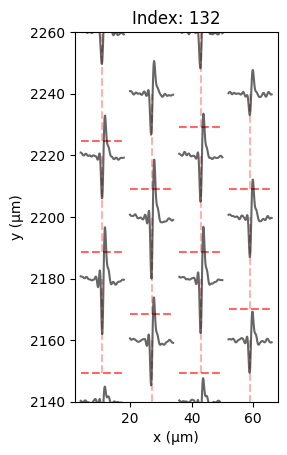

188


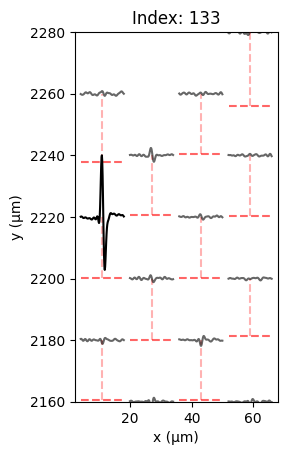

193


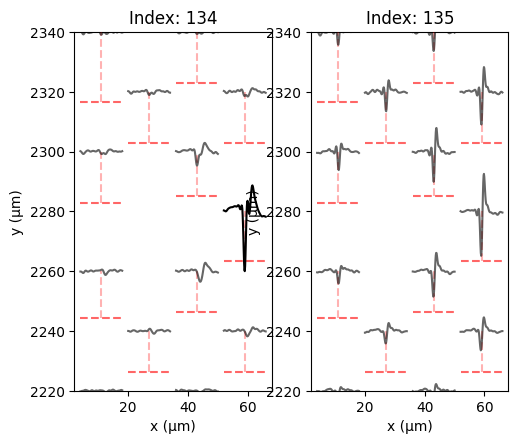

192


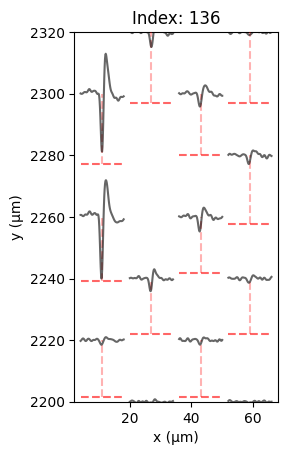

196


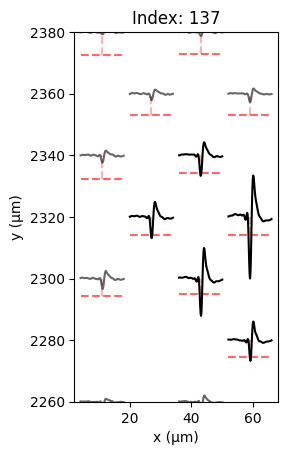

199


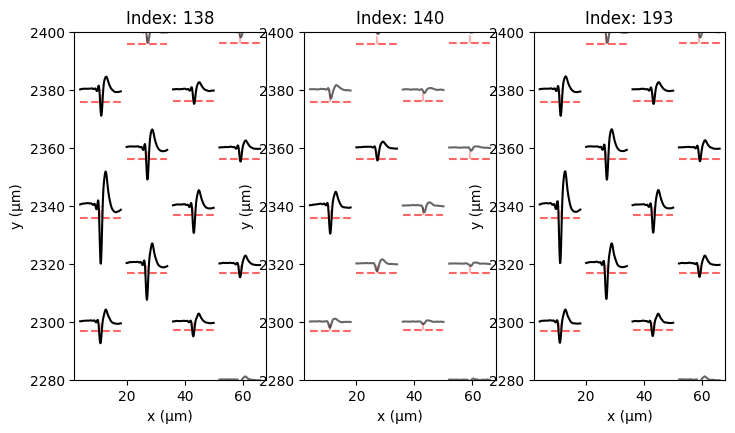

198


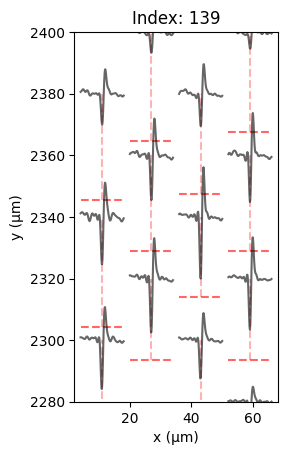

201


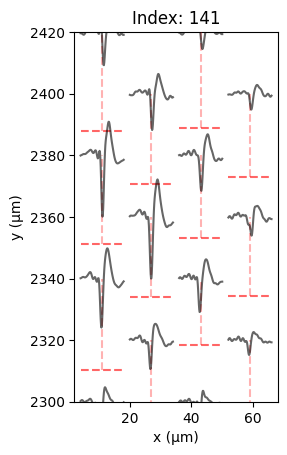

203


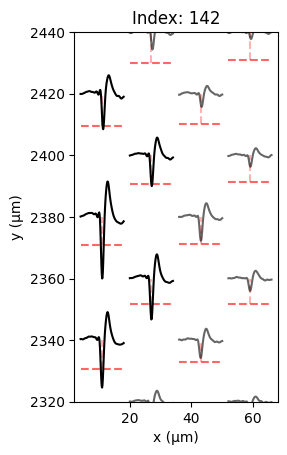

205


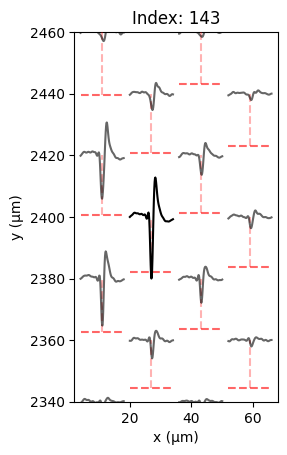

206


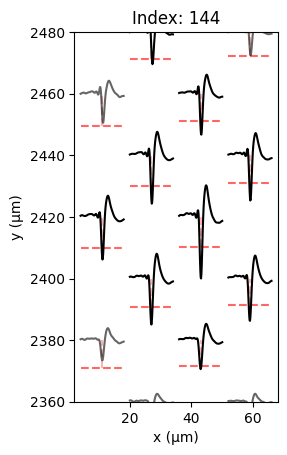

207


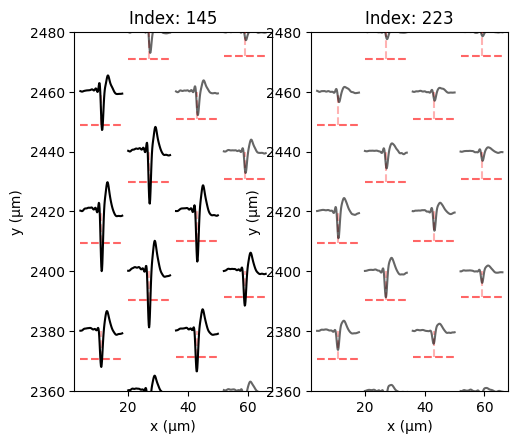

204


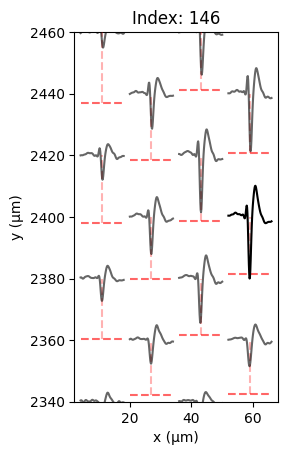

208


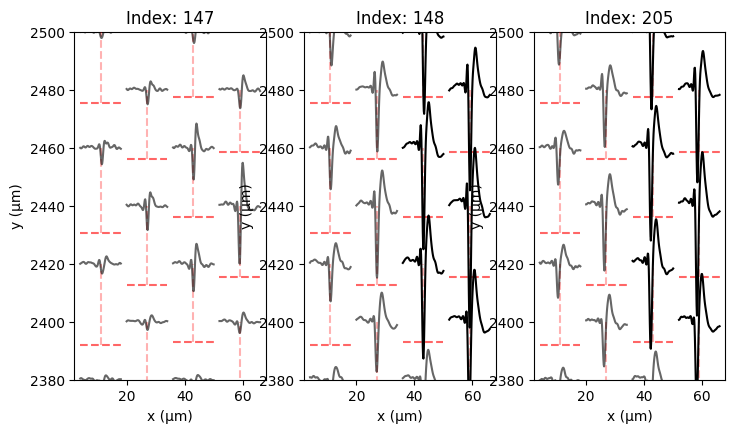

209


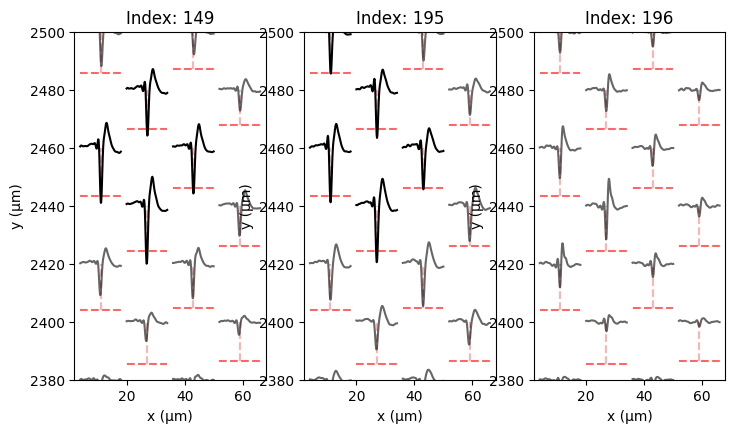

211


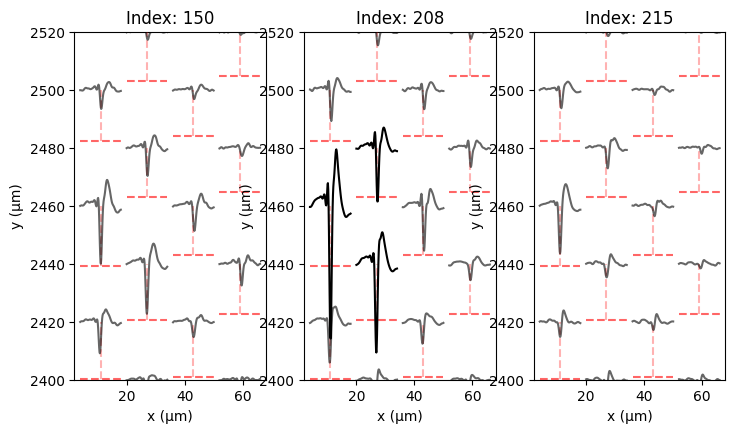

212


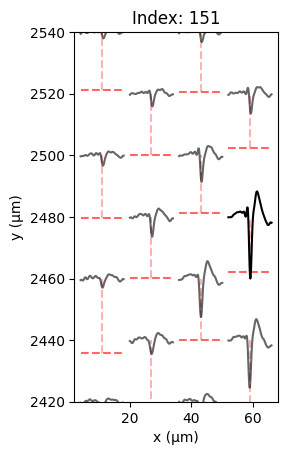

215


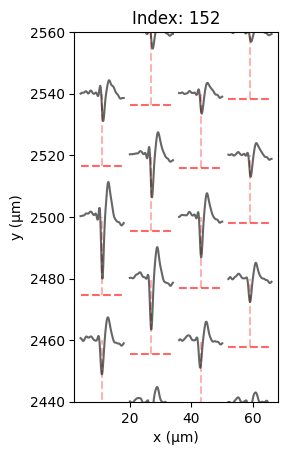

217


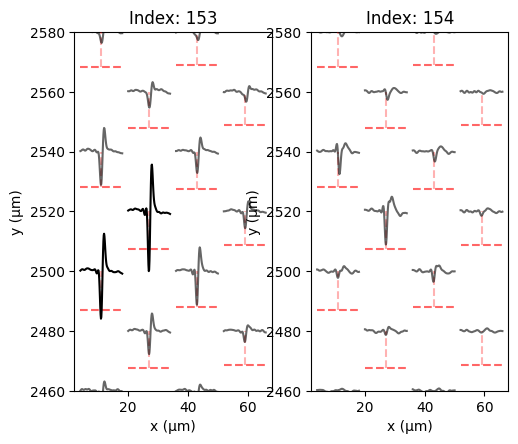

224


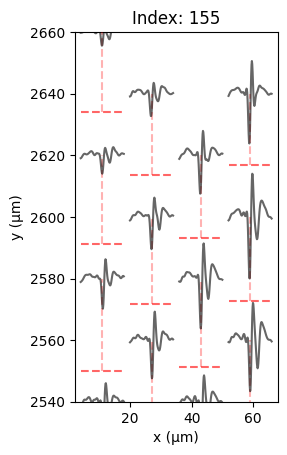

230


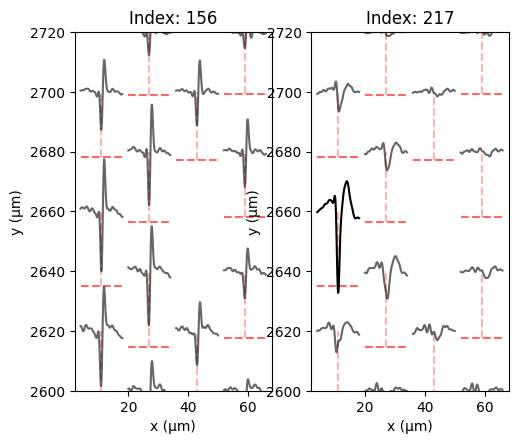

229


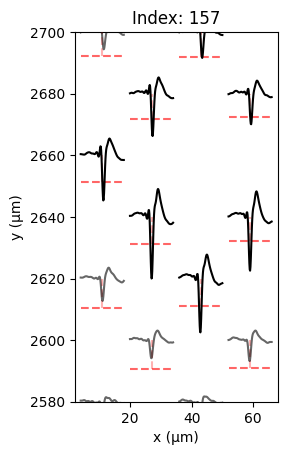

232


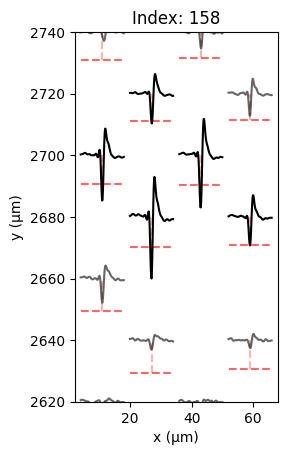

235


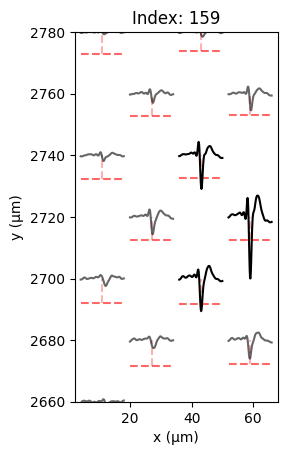

237


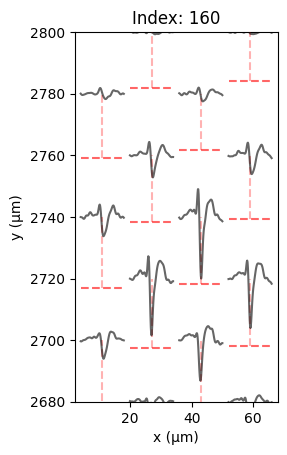

238


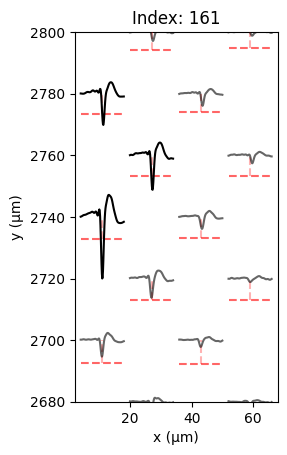

240


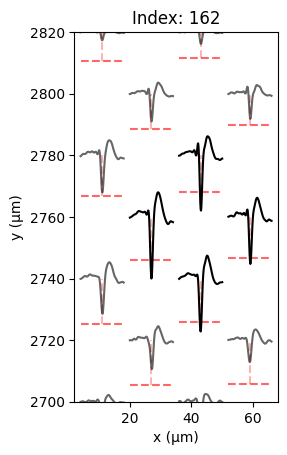

242


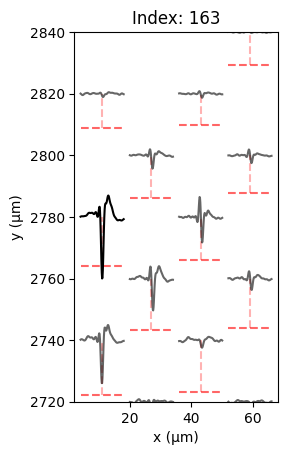

26


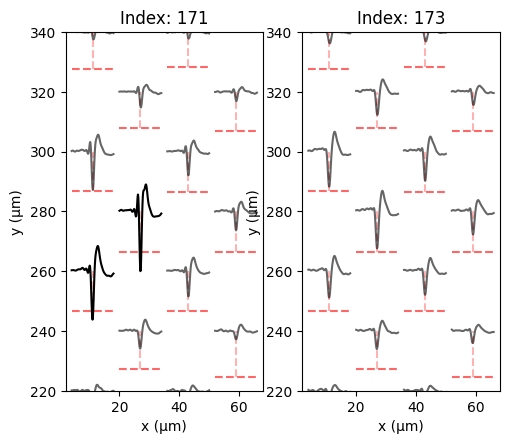

33


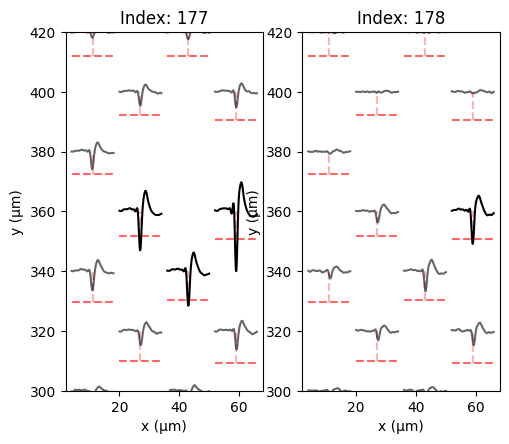

41


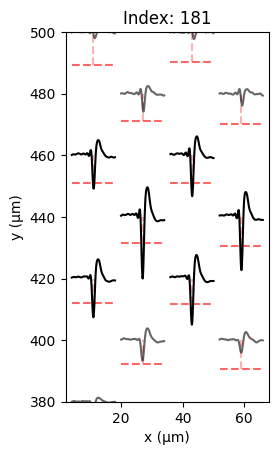

45


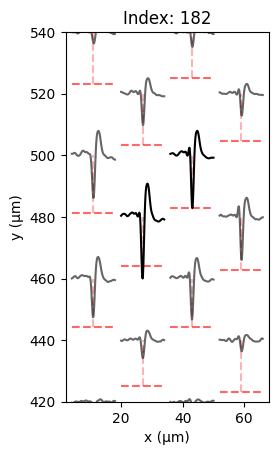

46


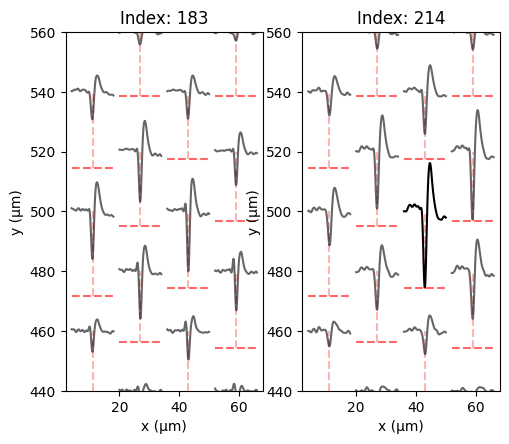

202


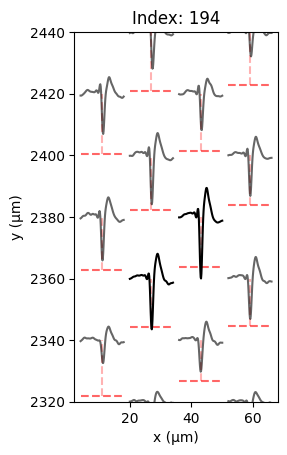

227


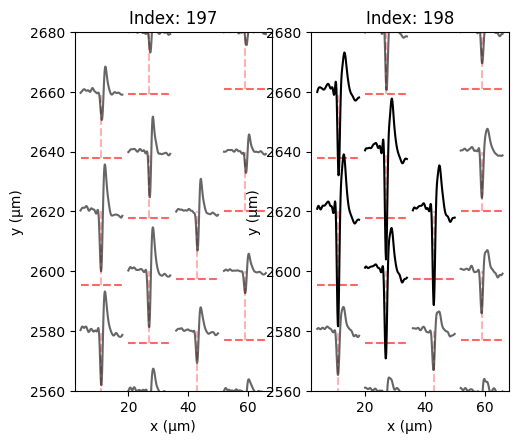

11


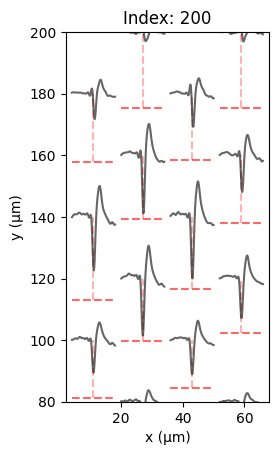

86


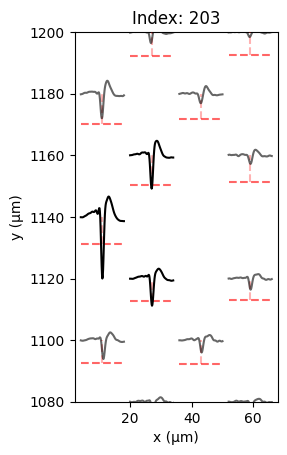

218


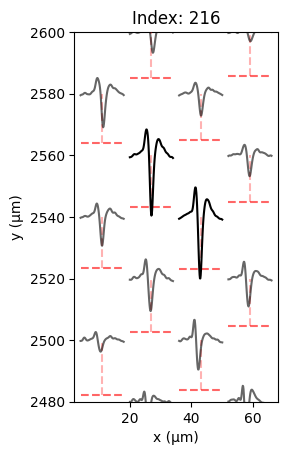

35


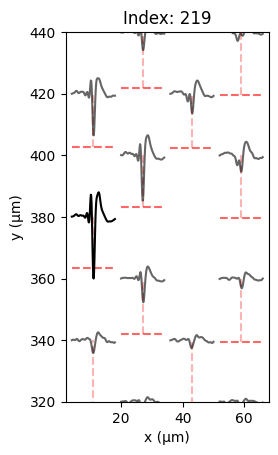

139


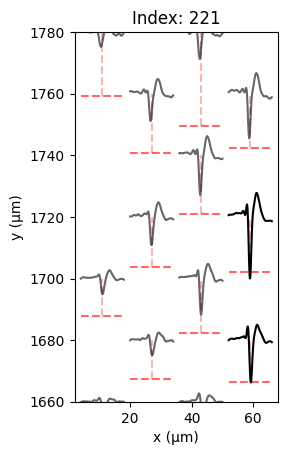

94


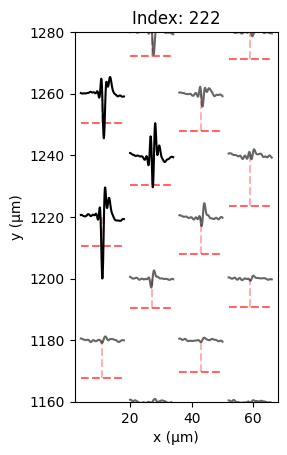

177


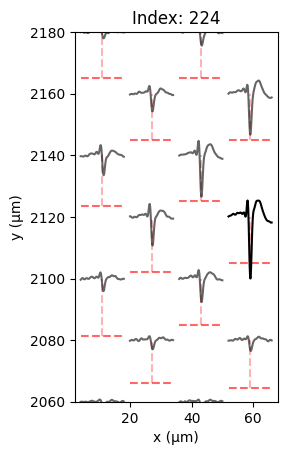

184


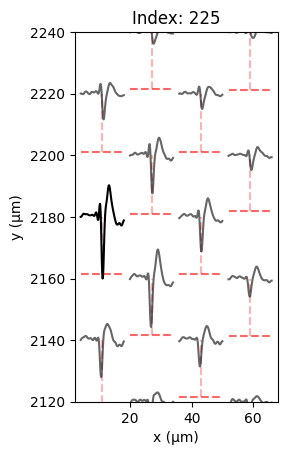

In [17]:
for chan, units in chan_to_ks_unit.items():
    kwargs = None
    print(chan)
    fig, axes = plt.subplots(ncols=len(units), figsize=(2.8*len(units), 4.8))
    axes = np.atleast_1d(axes)
    for i, unit in enumerate(units):
        if kwargs is None:
            kwargs = unit.plot(chans_rms=CHANS_RMS, axis=axes[i])
        else:
            unit.plot(**kwargs, axis=axes[i])
    plt.show()

### Extract surronding area (only needed for seeing if window RMS different than entire RMS)

In [95]:
NUM_WFS = 300
MS_BEFORE = 25
MS_AFTER = 25

np.random.seed(231)
##
def extract_templates(unit_idx):
    unit = ks_units[unit_idx]
    
    sf = unit.recording.get_sampling_frequency()
    templates = np.zeros((unit.recording.get_num_channels(), int(MS_BEFORE * sf)+int(MS_AFTER * sf)+1), dtype=float)
    traces_squared = np.zeros(unit.recording.get_num_channels(), dtype=float)
    for _ in range(NUM_WFS):
        wf = unit.get_waveforms(ms_before=MS_BEFORE, ms_after=MS_AFTER)
        templates += wf
        traces_squared += np.sum(np.square(wf), axis=1)
        
    center = templates.shape[1] // 2
    templates = templates[:, center-60:center+61]
    rms = np.sqrt(traces_squared/(wf.shape[1]*NUM_WFS))
    
    return unit_idx, templates / NUM_WFS / rms[:, None]

with Pool(processes=12) as pool:
    for unit_idx, templates in tqdm(pool.imap(extract_templates, range(len(ks_units))), total=len(ks_units)):
        ks_units[unit_idx].templates_rms_window = templates

100%|██████████| 226/226 [03:19<00:00,  1.13it/s]


## Electrodes crossing X*RMS

In [7]:
RMS_THRESH = 5

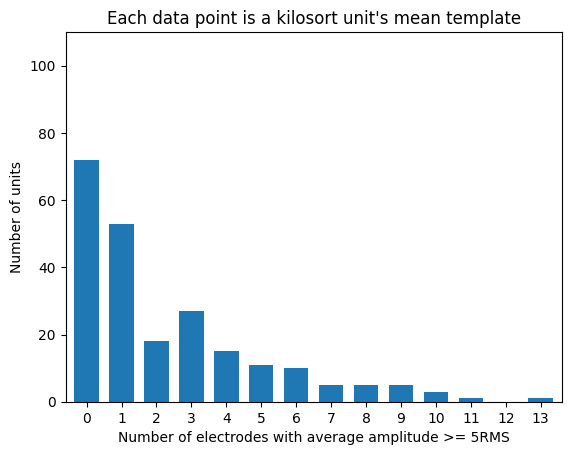

101 units have at least 2 electrodes cross 5RMS
67 units have at least 2 electrodes cross 5RMS and at least 1 non-zero latency electrode


In [110]:
num_elecs = []
for unit in ks_units:   
    amps = np.min(unit.templates, axis=1)
    num = np.sum(amps <= -RMS_THRESH * CHANS_RMS)
    num_elecs.append(num)
num_elecs = np.array(num_elecs)

plot.bar(num_elecs, width=0.7, xmax=13)

plt.title("Each data point is a kilosort unit's mean template")
plt.xlabel(f"Number of electrodes with average amplitude >= {RMS_THRESH}RMS")
plt.ylabel("Number of units")
plt.ylim(0, 110)
plt.show()

print(f"{np.sum(num_elecs >= 2)} units have at least 2 electrodes cross {RMS_THRESH}RMS")

num_units = 0
for unit in ks_units:   
    amps = np.min(unit.templates, axis=1)
    elecs = amps <= -RMS_THRESH * CHANS_RMS
    if np.sum(elecs) < 2:
        continue
    
    first_elec = np.argmin(amps[elecs])
    latencies = np.argmin(unit.templates[elecs], axis=1)
    latencies -= latencies[first_elec]
        
    if np.sum(latencies != 0) > 1:
        num_units += 1

print(f"{num_units} units have at least 2 electrodes cross {RMS_THRESH}RMS and at least 1 non-zero latency electrode")

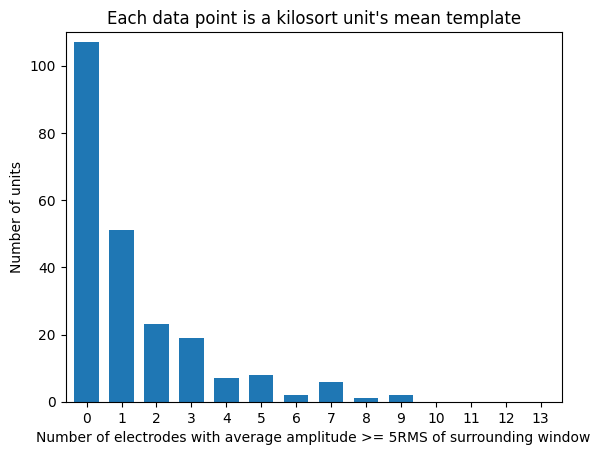

68 units have at least 2 electrodes cross 5RMS
35 units have at least 2 electrodes cross 5RMS and at least 1 non-zero latency electrode


In [111]:
num_elecs = []
for unit in ks_units:   
    amps = np.min(unit.templates_rms_window, axis=1)
    num = np.sum(amps <= -RMS_THRESH)
    num_elecs.append(num)
num_elecs = np.array(num_elecs)

plot.bar(num_elecs, width=0.7, xmax=13)

plt.title("Each data point is a kilosort unit's mean template")
plt.xlabel(f"Number of electrodes with average amplitude >= {RMS_THRESH}RMS of surrounding window")
plt.ylabel("Number of units")
plt.ylim(0, 110)
plt.show()

print(f"{np.sum(num_elecs >= 2)} units have at least 2 electrodes cross {RMS_THRESH}RMS")

num_units = 0
for unit in ks_units:   
    amps = np.min(unit.templates_rms_window, axis=1)
    elecs = amps <= -RMS_THRESH
    if np.sum(elecs) < 2:
        continue
    
    first_elec = np.argmin(amps[elecs])
    latencies = np.argmin(unit.templates[elecs], axis=1)
    latencies -= latencies[first_elec]
        
    if np.sum(latencies != 0) > 1:
        num_units += 1

print(f"{num_units} units have at least 2 electrodes cross {RMS_THRESH}RMS and at least 1 non-zero latency electrode")

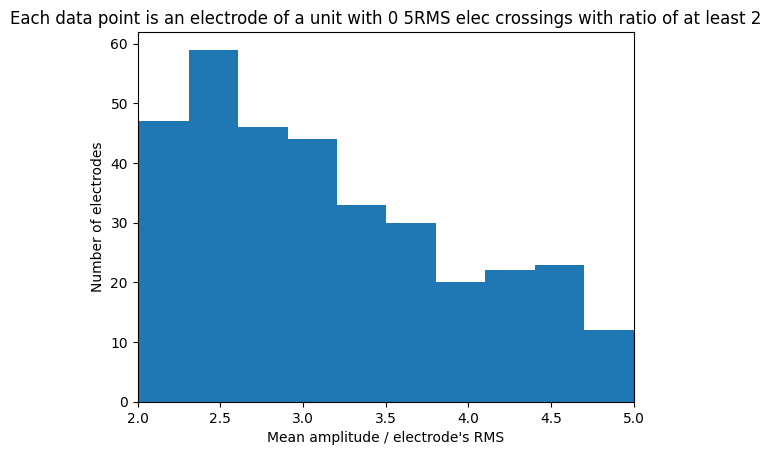

In [10]:
# Examine units with no electrodes crossing 5RMS
# NEEDS TO BE RUN AFTER PREVIOUS CELL

zeros = np.flatnonzero(num_elecs == 0)
ratios = []
for idx in zeros:
    unit = ks_units[idx]
    ratio = unit.templates.T / CHANS_RMS
    ratios.append(np.min(ratio, axis=0))
    
    # plt.plot(ratio, alpha=0.8)
    # plt.title("Each wave is mean waveform on an electrode")
    # plt.xlabel("Time (frames)")
    # plt.ylabel("Voltage / electrode's RMS")
    # plt.show()
    
ratios = -np.array(ratios)

plt.hist(ratios[ratios >= 2])
plt.xlim(2, 5)
plt.xlabel("Mean amplitude / electrode's RMS")
plt.ylabel("Number of electrodes")
plt.title("Each data point is an electrode of a unit with 0 5RMS elec crossings with ratio of at least 2")
plt.show()

## Units sharing electrodes

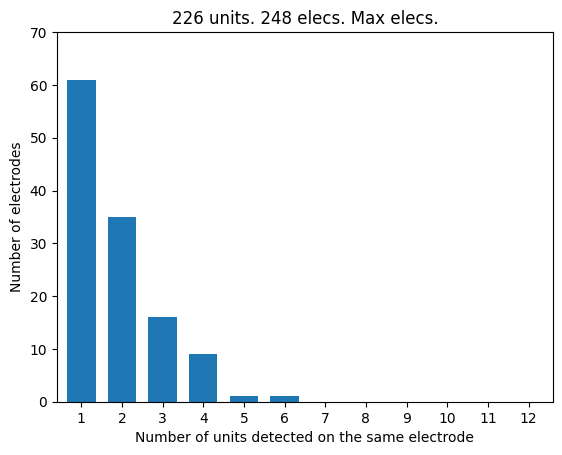

In [11]:
chans = []
for unit in ks_units:
    amps = np.min(unit.templates, axis=1)
    chan = np.argmin(amps)
    chans.append(chan)
    
_, counts = np.unique(chans, return_counts=True)

plot.bar(counts, xmax=12)

plt.title(f"{len(KILOSORT)} units. {KILOSORT.recording.get_num_channels()} elecs. Max elecs.")

plt.xlabel("Number of units detected on the same electrode")

plt.ylabel("Number of electrodes")
plt.ylim(0, 70)

plt.show()


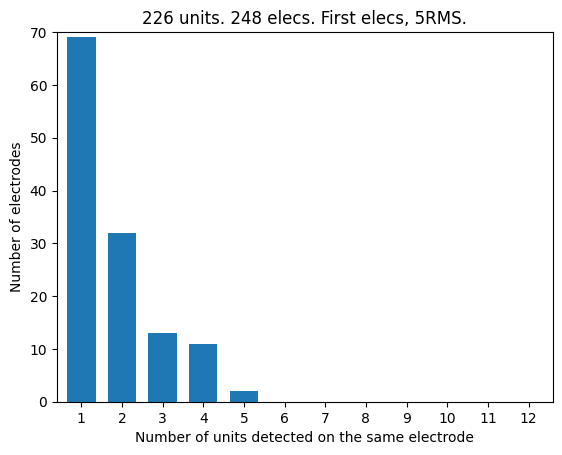

In [13]:
RMS_THRESH = 5

chans = []
for unit in ks_units:    
    amps = np.min(unit.templates, axis=1)
    elec_mask = amps < -RMS_THRESH * CHANS_RMS
    elecs = np.flatnonzero(elec_mask)
    if elecs.size == 0:
        elecs = [np.argmin(amps)]
    
    latencies = np.argmin(unit.templates, axis=1)
    min_latency = np.min(np.argmin(unit.templates[elecs], axis=1))
    chan = None
    min_amp = np.inf
    for elec in elecs:
        if latencies[elec] == min_latency and amps[elec] < min_amp:
            chan = elec
            min_amp = amps[elec]
    chans.append(chan)
    
_, counts = np.unique(chans, return_counts=True)

plot.bar(counts, xmax=12)

plt.title(f"{len(KILOSORT)} units. {KILOSORT.recording.get_num_channels()} elecs. First elecs, {RMS_THRESH}RMS.")

plt.xlabel("Number of units detected on the same electrode")

plt.ylabel("Number of electrodes")
plt.ylim(0, 70)

plt.show()


## Extract unit.spike_matrix

In [14]:
RMS_THRESH = 5

In [15]:
NUM_SPIKES = 500
LATENCY_BUFFER = 0
np.random.seed(101)
##
for unit in tqdm(ks_units):
    # Get templates and which elecs to check
    temps = unit.templates
    amps = np.min(unit.templates, axis=1)
    elec_mask = amps < -RMS_THRESH * CHANS_RMS
    elecs = np.flatnonzero(elec_mask)
    elecs = elecs[np.argsort(amps[elec_mask])]  # Sort elecs by descending order of amplitude
    unit.elecs = elecs
    unit.max_elec = np.argmin(amps)
    if elecs.size < 2:
        continue
    
    # Get template latencies and amplitudes
    temps_latencies = np.argmin(temps[elecs, :], axis=1)
    max_elec = np.argmin(amps[elecs])
    temps_latencies -= temps_latencies[max_elec]
    unit.temps_latencies = temps_latencies
    unit.temps_amps = np.min(temps[elecs, :], axis=1)

    # Examine certain units from bar plot
    # if np.sum(temps_latencies < 0) == 7:
    #     plot.plot_wf(temps)
    #     plt.show()
    # else:
    #     continue

    # Get window around individual spikes. 5 is buffer around latency (expected maximum deviation from template latency)
    n_before = np.abs(np.min(temps_latencies)) + 5 
    n_after = np.abs(np.max(temps_latencies)) + 5 + 1
    samp_freq = KILOSORT.recording.get_sampling_frequency()

    # Get latencies and amplitudes for individual spikes
    spike_matrix = [[], []]  # [latencies], [amplitudes]
    for _ in range(NUM_SPIKES):
        wfs = unit.get_waveforms(ms_before=n_before/samp_freq, ms_after=n_after/samp_freq, chans=elecs)
        # wfs = unit.get_waveforms(ms_before=2, ms_after=2, chans=elecs)
        
        latencies = np.argmin(wfs, axis=1)
        spike_matrix[1].append(wfs[np.arange(wfs.shape[0]), latencies]) 
        latencies -= latencies[max_elec]
        spike_matrix[0].append(latencies)
    unit.spike_matrix = np.array(spike_matrix)

  0%|          | 0/226 [00:00<?, ?it/s]

100%|██████████| 226/226 [00:56<00:00,  4.04it/s]


## Latency analysis

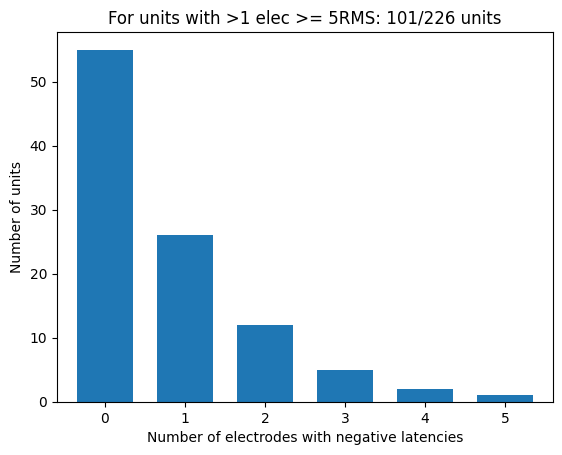

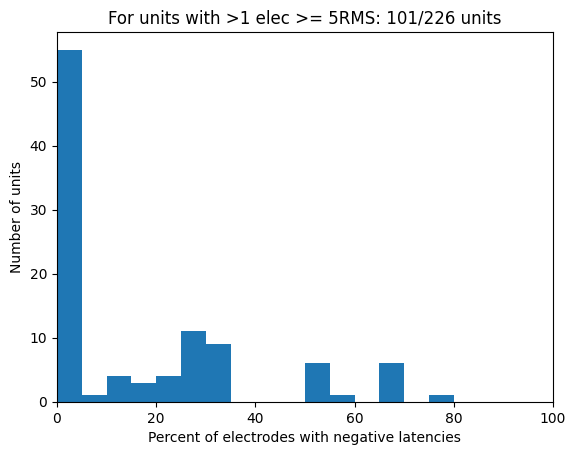

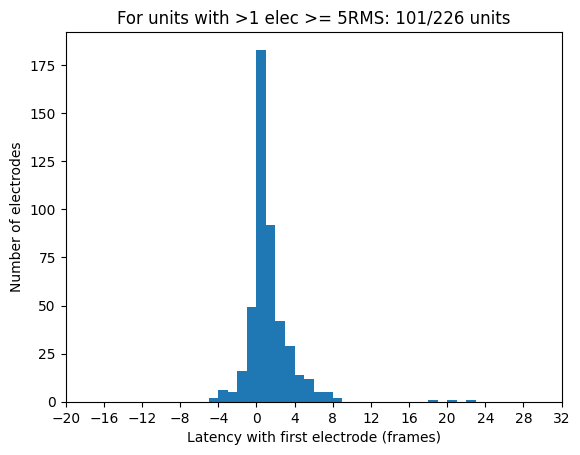

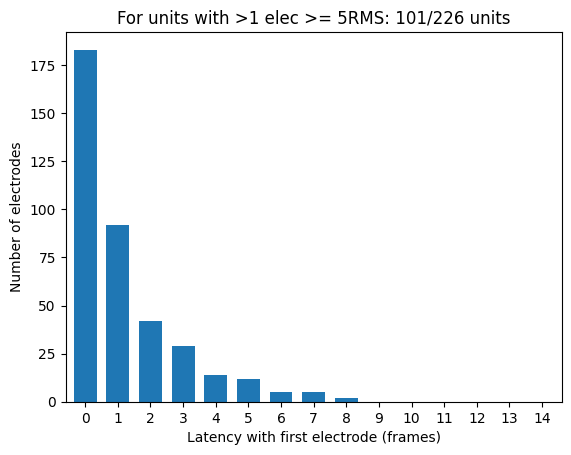

In [17]:
nums_elecs_before_max = []
p_elecs_before_max = []
all_latencies = []
for unit in ks_units:
    if unit.elecs.size < 2:
        continue
    
    nums_elecs = np.sum(unit.temps_latencies < 0)
    nums_elecs_before_max.append(nums_elecs)
    p_elecs_before_max.append(nums_elecs / unit.temps_latencies.size * 100)

    all_latencies.extend(unit.temps_latencies)

plot.bar(nums_elecs_before_max)
plt.title(f"For units with >1 elec >= {RMS_THRESH}RMS: {len(nums_elecs_before_max)}/{len(ks_units)} units")
plt.ylabel("Number of units")
plt.xlabel("Number of electrodes with negative latencies")
plt.show()

plot.hist(p_elecs_before_max, xlim=(0, 100), bins=20)
plt.title(f"For units with >1 elec >= {RMS_THRESH}RMS: {len(nums_elecs_before_max)}/{len(ks_units)} units")
plt.ylabel("Number of units")
plt.xlabel("Percent of electrodes with negative latencies")
plt.show()

plot.hist(all_latencies, bins=np.arange(min(all_latencies), max(all_latencies)))
plt.title(f"For units with >1 elec >= {RMS_THRESH}RMS: {len(nums_elecs_before_max)}/{len(ks_units)} units")

plt.ylabel("Number of electrodes")

plt.xlabel("Latency with first electrode (frames)")
plt.xticks(np.arange(-20, 33, 4))
# plt.xlim(-8, 8)

plt.show()


# To match with si_rec.ipynb
plot.bar([l for l in all_latencies if 0 <= l <= 14], xmax=14)
plt.title(f"For units with >1 elec >= {RMS_THRESH}RMS: {len(nums_elecs_before_max)}/{len(ks_units)} units")

plt.ylabel("Number of electrodes")

plt.xlabel("Latency with first electrode (frames)")

plt.show()

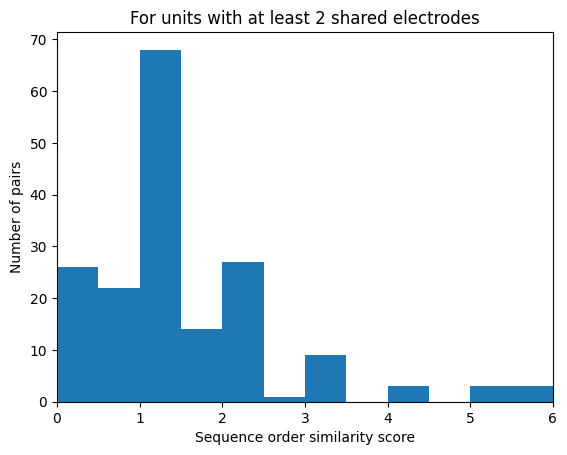

In [58]:
# Latency similarity between units with at least two matching electrodes
seq_order_scores = []
for i in range(len(ks_units)):
    for j in range(i+1, len(ks_units)):
        unit1 = ks_units[i]
        unit2 = ks_units[j]
        
        _, overlap1, overlap2 = np.intersect1d(unit1.elecs, unit2.elecs, return_indices=True, assume_unique=True)
        if overlap1.size < 2:
            continue
        
        latencies1 = unit1.temps_latencies[overlap1] # / KILOSORT.recording.get_sampling_frequency()
        latencies2 = unit2.temps_latencies[overlap2] # / KILOSORT.recording.get_sampling_frequency()
        
        rel_latencies1 = latencies1[1:] - latencies1[0]
        rel_latencies2 = latencies2[1:] - latencies2[0]
        score = np.mean(np.abs(rel_latencies1 - rel_latencies2))
        seq_order_scores.append(score)

plot.hist(seq_order_scores, bins=12)

plt.title("For units with at least 2 shared electrodes")
plt.xlabel("Sequence order similarity score")
plt.xlim(0, 6)

plt.ylabel("Number of pairs")
plt.show()

100%|██████████| 226/226 [00:00<00:00, 361.23it/s]


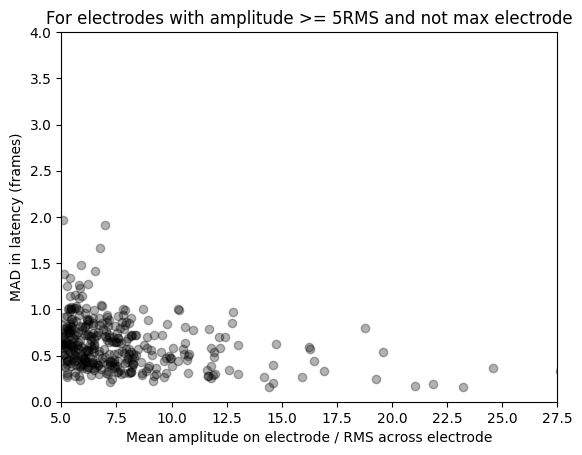

In [20]:
for unit in tqdm(ks_units):
    if unit.elecs.size < 2:
        continue
    
    for e in range(1, len(unit.elecs)):  # 1 to skip max elec since spikes are centered on that
        # Only select spikes where amp >= RMS_THRESH*RMS. If less than this, spike not detected on that electrode
        elec = unit.elecs[e]
        amps = unit.spike_matrix[1, :, e]
        latencies = unit.spike_matrix[0, amps <= -RMS_THRESH*CHANS_RMS[elec], e]
        mad = np.mean(np.abs(latencies - unit.temps_latencies[e]))
        plt.scatter(-unit.temps_amps[e] / CHANS_RMS[elec], mad, color="black", alpha=0.3)  # alpha=0.05
        
        # assert amp / CHANS_RMS[elec] >= RMS_THRESH, amp/CHANS_RMS[elec]  # Sanity check 

plt.title(f"For electrodes with amplitude >= {RMS_THRESH}RMS and not max electrode")

plt.xticks(np.arange(5, 56, 5)/2)
plt.xlim(RMS_THRESH, 27.5)
# plt.xlim(RMS_THRESH, 10)
plt.xlabel("Mean amplitude on electrode / RMS across electrode")

plt.yticks(range(0, 13))
# plt.ylim(0, 13)
plt.yticks(np.arange(0, 13)/2)
plt.ylim(0, 4)
plt.ylabel("MAD in latency (frames)")

plt.show()

100%|██████████| 4/4 [00:03<00:00,  1.20it/s]


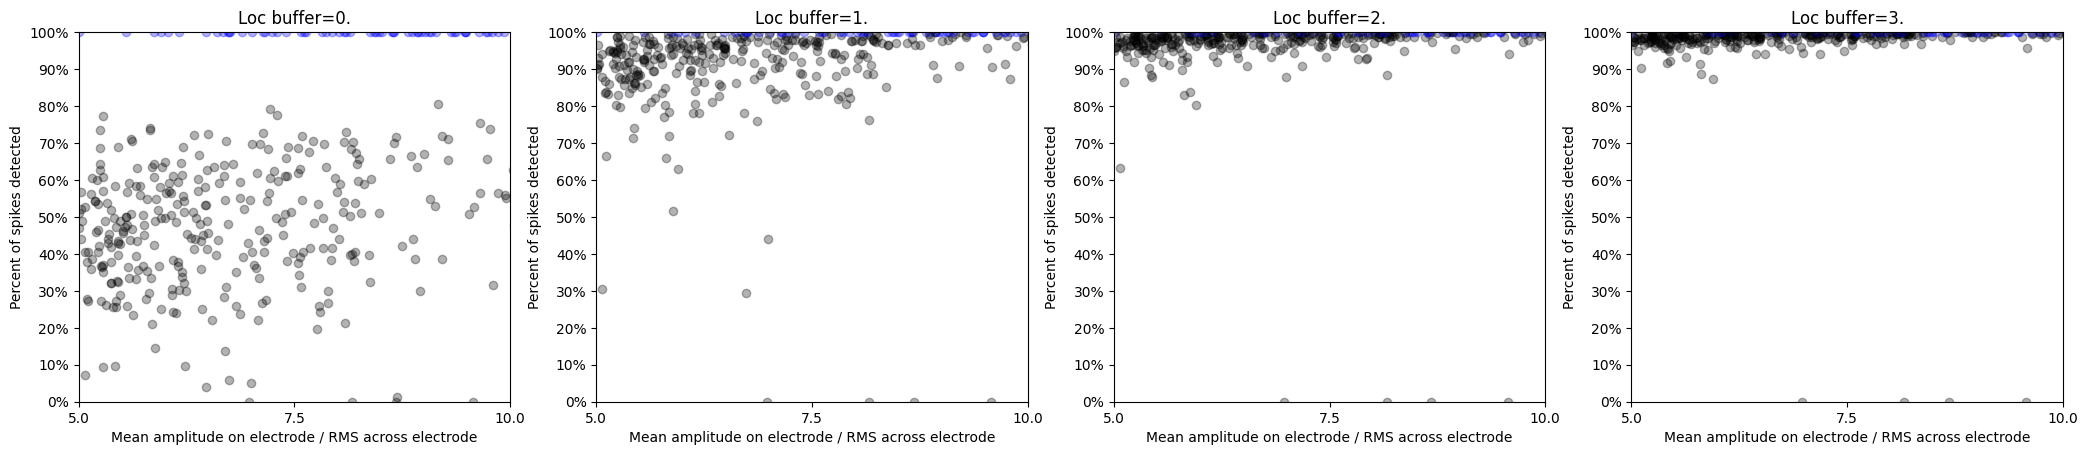

In [21]:
LOC_BUFFERS = [0, 1, 2, 3]
NEEDS_THRESH = False  # If True, spike detected if latency within loc_buffer and crosses RMS_THRESH. Else, only latency matters
OUT_OF_TOTAL = True  # If True, percent detected is out of total kilosort spikes. Else, it is out of spikes whose amp cross RMS_THRESH (irrelevant if NEEDS_THRESH is False)
##
fig, axes = plt.subplots(1, len(LOC_BUFFERS), figsize=(6.4*len(LOC_BUFFERS), 4.8))
axes = np.atleast_1d(axes)

# Loop through different paramaters
for col, loc_buffer in tqdm(enumerate(LOC_BUFFERS), total=len(LOC_BUFFERS)):
    # Create plot
    for unit in ks_units:
        if unit.elecs.size < 2:
            continue
    
        for e in range(len(unit.elecs)):
            # Select spikes
            elec = unit.elecs[e]
            amps = unit.spike_matrix[1, :, e]
            if NEEDS_THRESH:
                latencies = unit.spike_matrix[0, amps <= -RMS_THRESH*CHANS_RMS[elec], e]
            else:
                latencies = unit.spike_matrix[0, :, e]
            
            # Find % of detected spikes
            latencies_diff = np.abs(latencies - unit.temps_latencies[e])
            p_detected = np.sum(latencies_diff <= loc_buffer) * 100
            if OUT_OF_TOTAL:
                p_detected /= len(amps)
            else:
                p_detected /= len(latencies_diff)
            
            if e == 0:
                color = "blue"
            else:
                color = "black"
            
            axes[col].scatter(-unit.temps_amps[e] / CHANS_RMS[elec], p_detected, color=color, alpha=0.3)  # alpha=0.05
            # axes[col].scatter(unit.temps_latencies[e], p_detected, color=color, alpha=0.05)  # alpha=0.05

    axes[col].set_title(f"Loc buffer={loc_buffer}.")

    axes[col].set_xticks(np.arange(5, 56, 5)/2)
    axes[col].set_xlim(RMS_THRESH, 10)
    axes[col].set_xlabel("Mean amplitude on electrode / RMS across electrode")
    # axes[col].set_xlabel("Latency (frames)")

    axes[col].set_ylabel("Percent of spikes detected")
    axes[col].set_yticks(range(0, 101, 10))
    axes[col].set_yticklabels([f"{p}%" for p in range(0, 101, 10)])
    axes[col].set_ylim(0, 100)

plt.show()

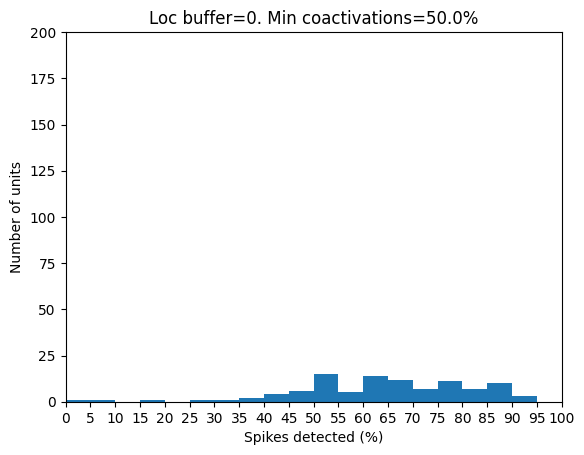

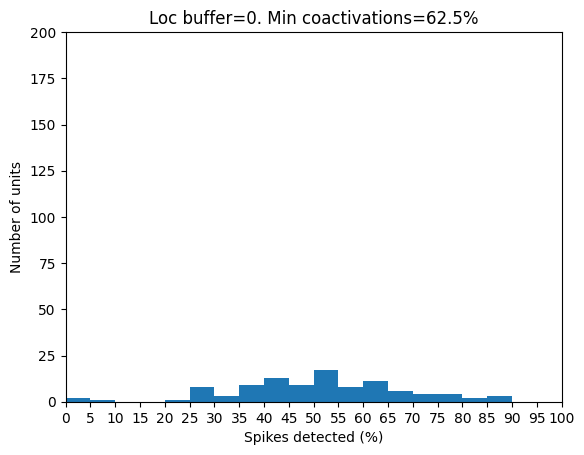

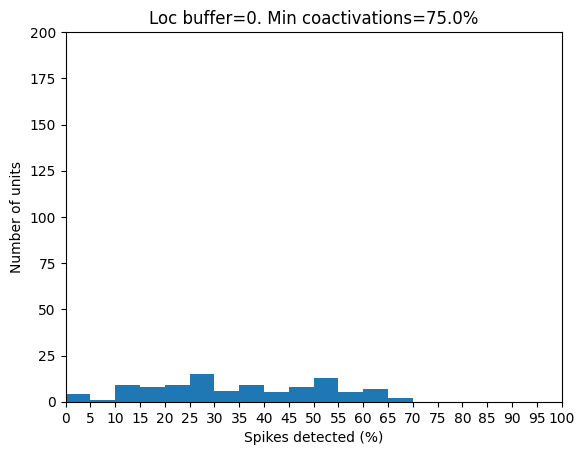

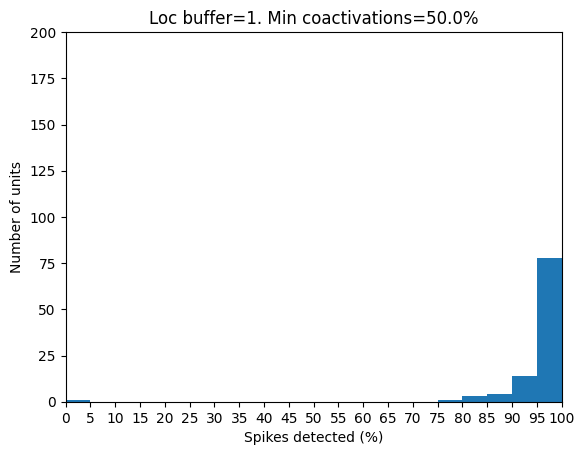

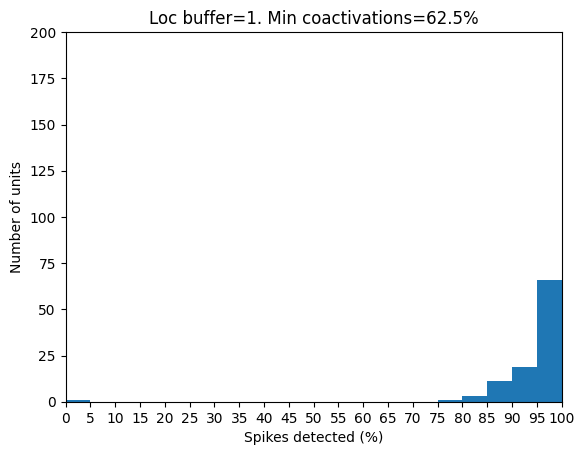

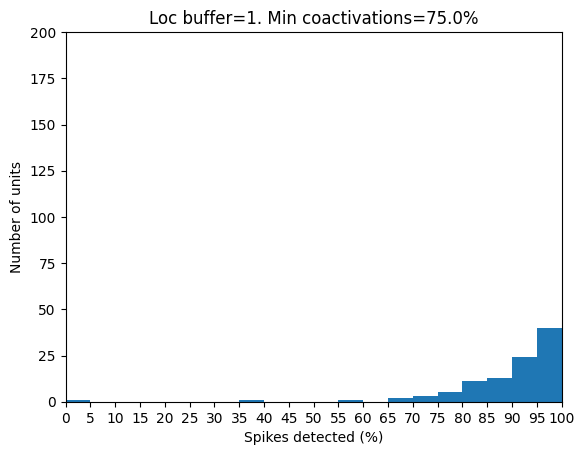

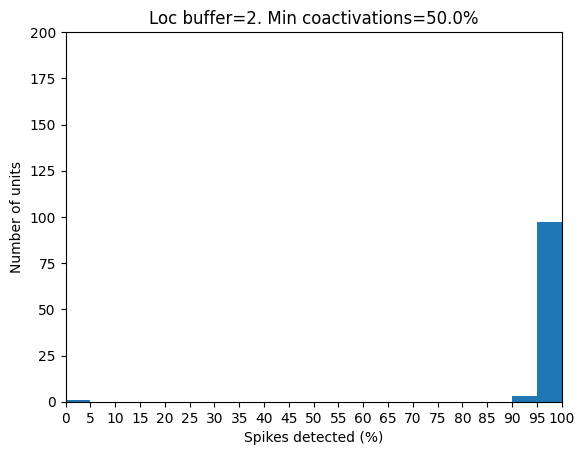

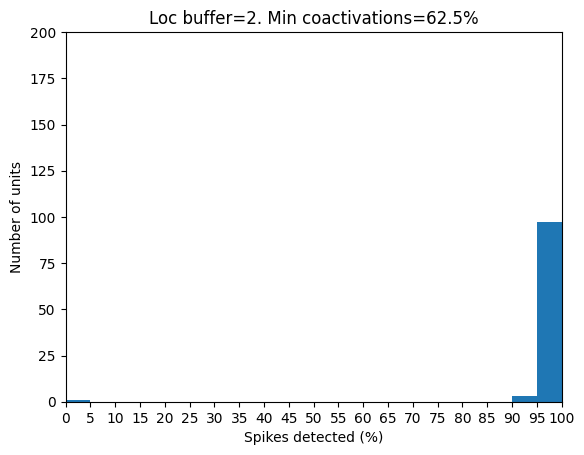

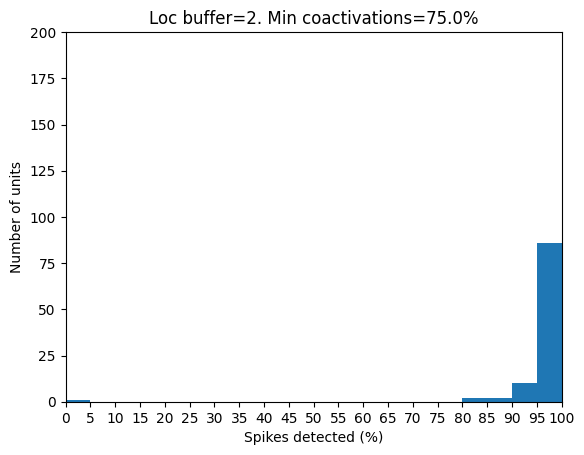

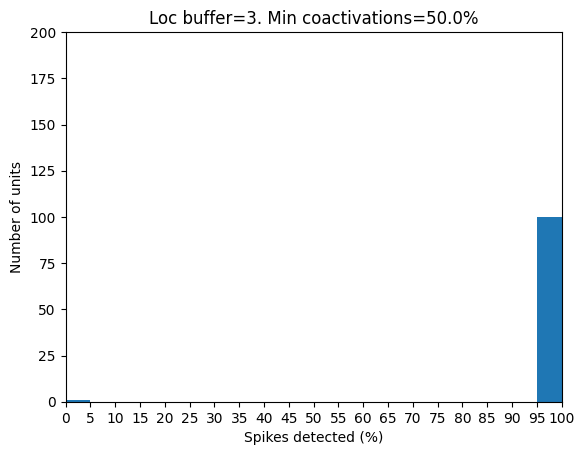

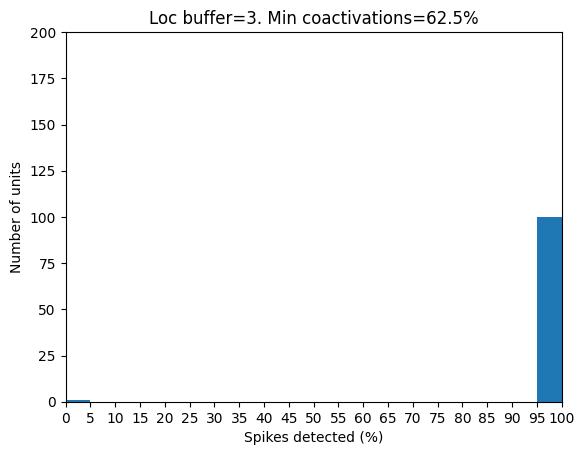

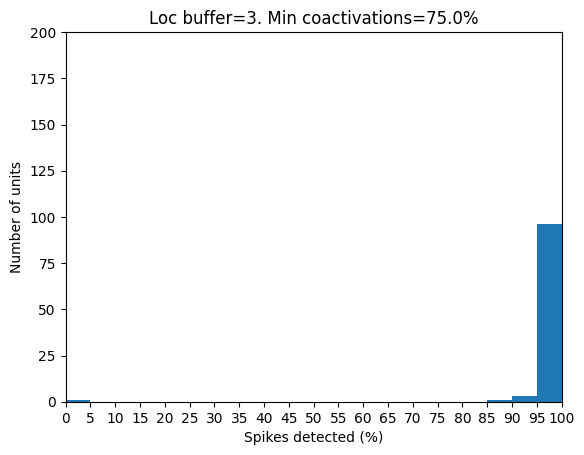

In [22]:
LOC_BUFFERS = [0, 1, 2, 3]
MIN_COCC = [0.5, 0.625, 0.75]
##
# Loop through parameters
for loc_buffer in LOC_BUFFERS:
    for min_cocc in MIN_COCC:
        # Now create plot
        p_spikes = []
        for unit in ks_units:
            if unit.elecs.size < 2:
                continue
            
            if isinstance(min_cocc, float):
                min_cocc_unit = max(2, min_cocc * unit.elecs.size)
            else:
                min_cocc_unit = min_cocc
            
            latencies = unit.spike_matrix[0]
            latencies_diff = np.abs(latencies - unit.temps_latencies)
            nums_matches = np.sum(latencies_diff <= loc_buffer, axis=1)
            num_detections = np.sum(nums_matches >= min_cocc_unit)
            p_spikes.append(num_detections / latencies.shape[0] * 100)
        
        plot.hist(p_spikes, bins=range(0, 101, 5))

        if isinstance(min_cocc, float):
            min_cocc = str(min_cocc * 100)+"%"
        plt.title(f"Loc buffer={loc_buffer}. Min coactivations={min_cocc}")

        plt.xlabel("Spikes detected (%)")
        # plt.xticks(range(0, 101, 10), [f"{p}%" for p in range(0, 101, 10)])
        plt.xticks(range(0, 101, 5), [f"{p}" for p in range(0, 101, 5)])
        plt.xlim(0, 100)

        plt.ylabel("Number of units")
        plt.ylim(0, 200)

        plt.show()

## Relative amplitude analysis

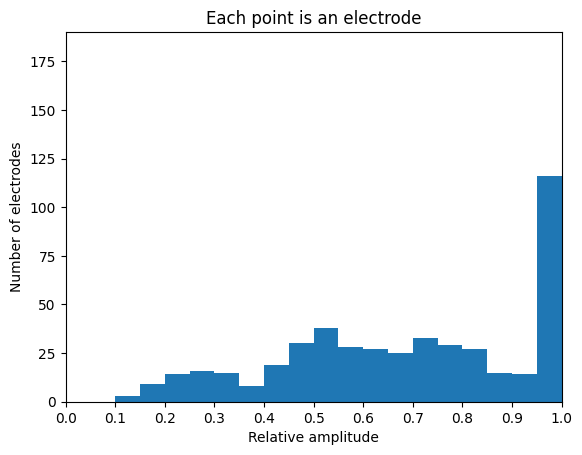

In [23]:
INCLUDE_MAX_ELEC = True  # Whether to include electrode with max amp (rel amp = 1) in histogram

hist_amps = []
for unit in ks_units:
    if unit.elecs.size < 2:
        continue
    
    amps = np.abs(unit.temps_amps)
    
    max_amp = np.max(amps)
    for amp in amps:
        if not INCLUDE_MAX_ELEC and amp == max_amp:
            continue
        hist_amps.append(amp / np.max(amps))
        
# print(np.sum(np.array(hist_amps)>0.95))
        
plot.hist(hist_amps, xlim=(0, 1), bins=np.arange(0, 1.01, 0.05))

title = "Each point is an electrode"
if not INCLUDE_MAX_ELEC:
    title += ", not including max elec"
plt.title(title)

plt.xlabel("Relative amplitude")
plt.xticks(np.arange(0, 1.001, 0.1))

plt.ylabel("Number of electrodes")
plt.ylim(0, 190)

plt.show()

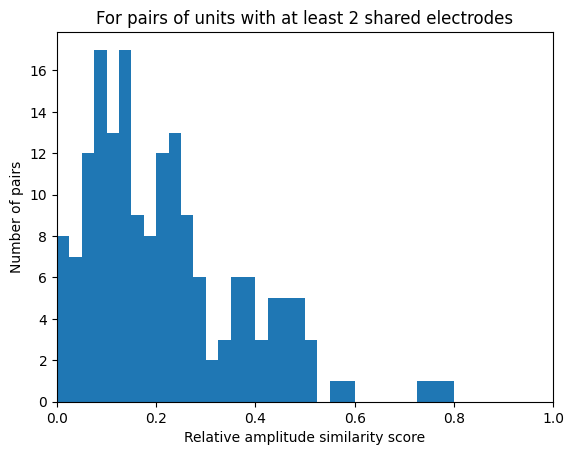

In [73]:
# Latency similarity between units with at least two matching electrodes
seq_order_scores = []
for i in range(len(ks_units)):
    for j in range(i+1, len(ks_units)):
        unit1 = ks_units[i]
        unit2 = ks_units[j]
        
        _, overlap1, overlap2 = np.intersect1d(unit1.elecs, unit2.elecs, return_indices=True, assume_unique=True)
        if overlap1.size < 2:
            continue
        
        amps1 = np.abs(np.min(unit1.templates[overlap1], axis=1))
        amps2 = np.abs(np.min(unit2.templates[overlap2], axis=1))
        
        rel_elec = np.argmax(amps1)
        rel_amps1 = amps1 / amps1[rel_elec]
        rel_amps2 = amps2 / amps2[rel_elec]
        
        score = np.mean(np.abs(rel_amps1 - rel_amps2))
        seq_order_scores.append(score)

plot.hist(seq_order_scores, range=(0, 1), bins=40)

plt.title("For pairs of units with at least 2 shared electrodes")
plt.xlabel("Relative amplitude similarity score")

plt.ylabel("Number of pairs")
plt.show()

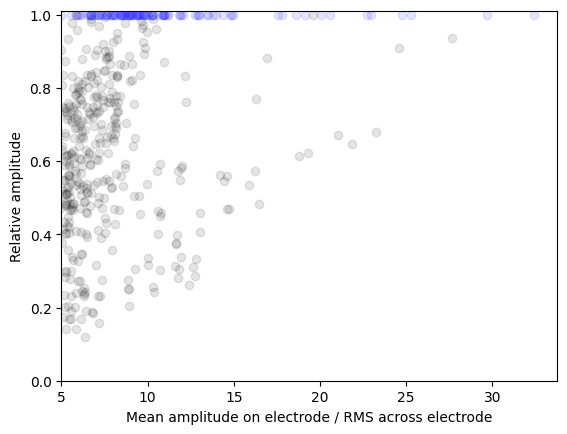

In [25]:
for unit in ks_units:
    if unit.elecs.size < 2:
        continue
    
    max_amp = unit.temps_amps[0]
    for e in range(len(unit.elecs)):
        if e == 0:
            color = "blue"
        else:
            color = "black"
        
        amp = unit.temps_amps[e]
        plt.scatter(-amp / CHANS_RMS[unit.elecs[e]], amp / max_amp, color=color, alpha=0.1)

plt.xlabel("Mean amplitude on electrode / RMS across electrode")
plt.xlim(RMS_THRESH)

plt.ylabel("Relative amplitude")
plt.ylim(0, 1.01)

plt.show()

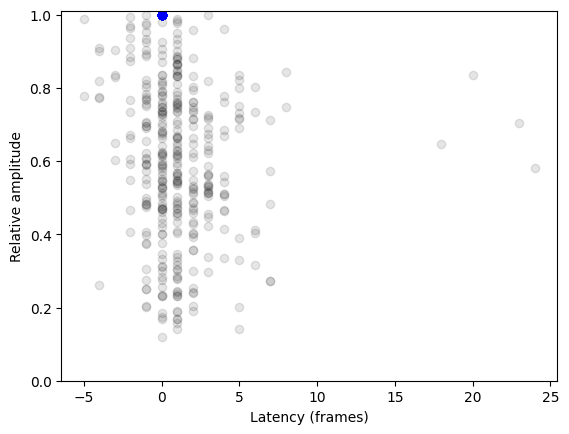

In [26]:
for unit in ks_units:
    if unit.elecs.size < 2:
        continue
    
    max_amp = unit.temps_amps[0]
    for e in range(len(unit.elecs)):
        if e == 0:
            color = "blue"
        else:
            color = "black"
        
        amp = unit.temps_amps[e]
        plt.scatter(unit.temps_latencies[e], amp / max_amp, color=color, alpha=0.1)

# plt.title("Each point is an electrode")

plt.xlabel("Latency (frames)")
# plt.xlim(-5, 5)

plt.ylabel("Relative amplitude")
plt.ylim(0, 1.01)

plt.show()

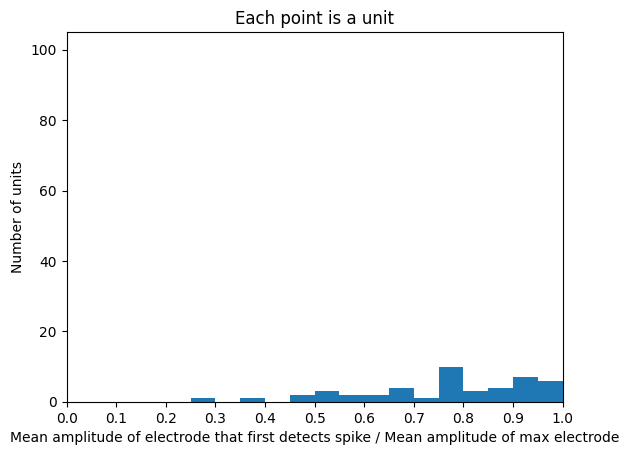

In [27]:
INCLUDE_MAX_ELEC = False  # If True, if max elec spikes first, include unit as a data point. Otherwise, don't include these units
##
rel_amps = []
for unit in ks_units:
    if unit.elecs.size < 2:
        continue
    
    min_latency = np.min(unit.temps_latencies)
    min_latency_elecs = np.flatnonzero(unit.temps_latencies == min_latency)
    min_latency_amp = np.min(unit.temps_amps[min_latency_elecs])
    
    if not INCLUDE_MAX_ELEC and min_latency_amp == unit.temps_amps[0]:
        continue
    rel_amps.append(min_latency_amp / unit.temps_amps[0])

bins = np.arange(0, 1.001, 0.05)
plot.hist(rel_amps, xlim=(0, 1), bins=bins)
    
plt.title("Each point is a unit")

plt.xlabel("Mean amplitude of electrode that first detects spike / Mean amplitude of max electrode")
plt.xticks(np.arange(0, 1.001, 0.1))

plt.ylabel("Number of units")
plt.ylim(0, 105)

plt.show()

  0%|          | 0/226 [00:00<?, ?it/s]

100%|██████████| 226/226 [00:00<00:00, 255.47it/s]


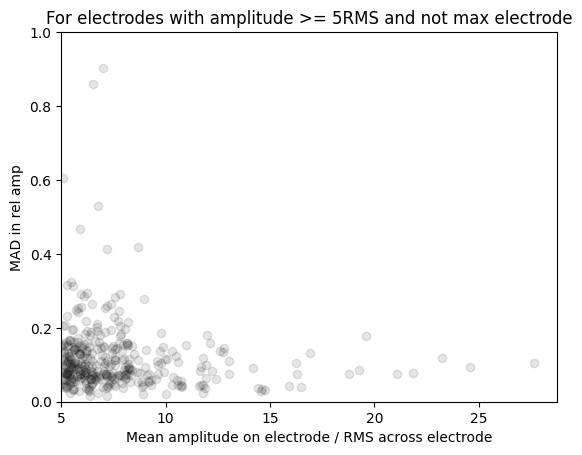

In [29]:
for unit in tqdm(ks_units):
    if unit.elecs.size < 2:
        continue
    
    for e in range(1, len(unit.elecs)):  # 1 to skip max elec since spikes are centered on that
        # Only select spikes where amp >= RMS_THRESH*RMS. If less than this, spike not detected on that electrode
        elec = unit.elecs[e]
        rel_amps = unit.spike_matrix[1, :, e] / unit.spike_matrix[1, :, 0]
        temp_rel_amp = unit.temps_amps[e] / unit.temps_amps[0]
        
        mad = np.mean(np.abs(rel_amps - temp_rel_amp))
        plt.scatter(-unit.temps_amps[e] / CHANS_RMS[elec], mad, color="black", alpha=0.1)  # alpha=0.05
        
        # assert amp / CHANS_RMS[elec] >= RMS_THRESH, amp/CHANS_RMS[elec]  # Sanity check 

plt.title(f"For electrodes with amplitude >= {RMS_THRESH}RMS and not max electrode")

plt.xlabel("Mean amplitude on electrode / RMS across electrode")
plt.xlim(RMS_THRESH)

plt.ylabel("MAD in rel amp")
plt.ylim(0, 1)

plt.show()

100%|██████████| 226/226 [00:00<00:00, 333.12it/s]


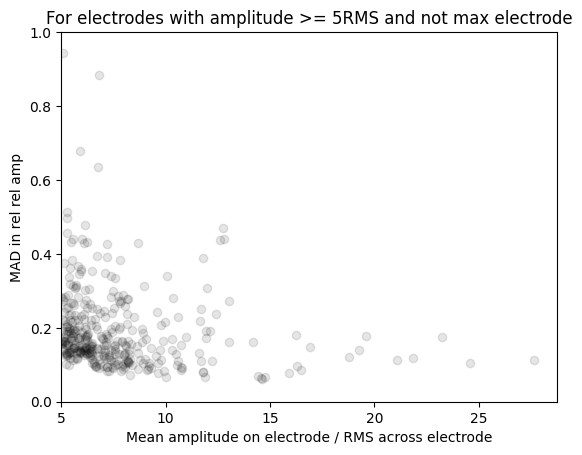

In [30]:
for unit in tqdm(ks_units):
    if unit.elecs.size < 2:
        continue
    
    for e in range(1, len(unit.elecs)):  # 1 to skip max elec since spikes are centered on that
        # Only select spikes where amp >= RMS_THRESH*RMS. If less than this, spike not detected on that electrode
        elec = unit.elecs[e]
        rel_amps = unit.spike_matrix[1, :, e] / unit.spike_matrix[1, :, 0]
        temp_rel_amp = unit.temps_amps[e] / unit.temps_amps[0]
        
        mad = np.mean(np.abs(rel_amps - temp_rel_amp)/temp_rel_amp)
        plt.scatter(-unit.temps_amps[e] / CHANS_RMS[elec], mad, color="black", alpha=0.1)  # alpha=0.05
        
        # assert amp / CHANS_RMS[elec] >= RMS_THRESH, amp/CHANS_RMS[elec]  # Sanity check 

plt.title(f"For electrodes with amplitude >= {RMS_THRESH}RMS and not max electrode")

plt.xlabel("Mean amplitude on electrode / RMS across electrode")
plt.xlim(RMS_THRESH)

plt.ylabel("MAD in rel rel amp")
plt.ylim(0, 1)

plt.show()

100%|██████████| 5/5 [00:04<00:00,  1.23it/s]


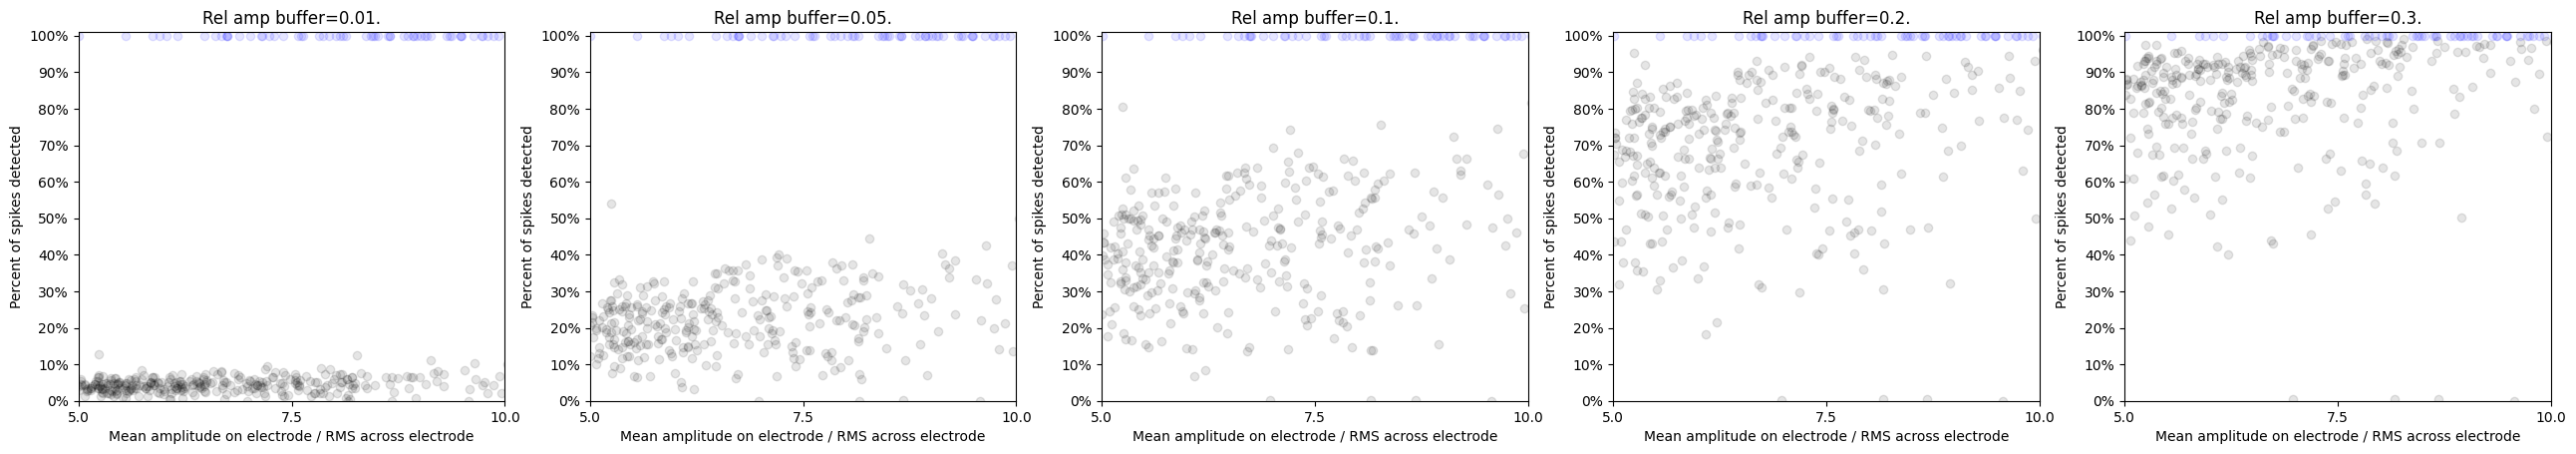

In [31]:
REL_AMP_BUFFERS = [0.01, 0.05, 0.1, 0.2, 0.3] # , 0.1, 0.2, 0.3
NEEDS_THRESH = False  # If True, spike detected if latency within loc_buffer and crosses RMS_THRESH. Else, only latency matters
OUT_OF_TOTAL = False  # If True, percent detected is out of total kilosort spikes. Else, it is out of spikes whose amp cross RMS_THRESH (irrelevant if NEEDS_THRESH is False)
##
fig, axes = plt.subplots(1, len(REL_AMP_BUFFERS), figsize=(6.4*len(REL_AMP_BUFFERS), 4.8))
axes = np.atleast_1d(axes)

# Loop through different paramaters
for col, rel_amp_buffer in tqdm(enumerate(REL_AMP_BUFFERS), total=len(REL_AMP_BUFFERS)):
    # Create plot
    for unit in ks_units:
        if unit.elecs.size < 2:
            continue
    
        for e in range(len(unit.elecs)):
            # Select spikes
            elec = unit.elecs[e]
            amps = unit.spike_matrix[1, :, e]
            if NEEDS_THRESH:
                spike_mask = amps <= -RMS_THRESH*CHANS_RMS[elec]
            else:
                spike_mask = np.arange(amps.size)
            
            rel_amps = amps[spike_mask] / unit.spike_matrix[1, spike_mask, 0]

            # Find % of detected spikes 
            temps_rel_amp = unit.temps_amps[e] / unit.temps_amps[0]
            
            rel_amps_diff = np.abs(rel_amps - temps_rel_amp) / temps_rel_amp
            p_detected = np.sum(rel_amps_diff <= rel_amp_buffer) * 100
            if OUT_OF_TOTAL:
                p_detected /= len(amps)
            else:
                p_detected /= len(rel_amps_diff)
            
            if e == 0:
                color = "blue"
            else:
                color = "black"
            
            axes[col].scatter(-unit.temps_amps[e] / CHANS_RMS[elec], p_detected, color=color, alpha=0.1)  # alpha=0.05
            # axes[col].scatter(temps_rel_amp, p_detected, color=color, alpha=0.3)  # alpha=0.05

    axes[col].set_title(f"Rel amp buffer={rel_amp_buffer}.")

    axes[col].set_xticks(np.arange(5, 56, 5)/2)
    axes[col].set_xlim(RMS_THRESH, 10)
    axes[col].set_xlabel("Mean amplitude on electrode / RMS across electrode")
    
    # axes[col].set_xlim(0, 1)
    # axes[col].set_xlabel("Relative amplitude")

    axes[col].set_ylabel("Percent of spikes detected")
    axes[col].set_yticks(range(0, 101, 10))
    axes[col].set_yticklabels([f"{p}%" for p in range(0, 101, 10)])
    axes[col].set_ylim(0, 101)

plt.show()

  0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 5/5 [00:00<00:00, 31.45it/s]


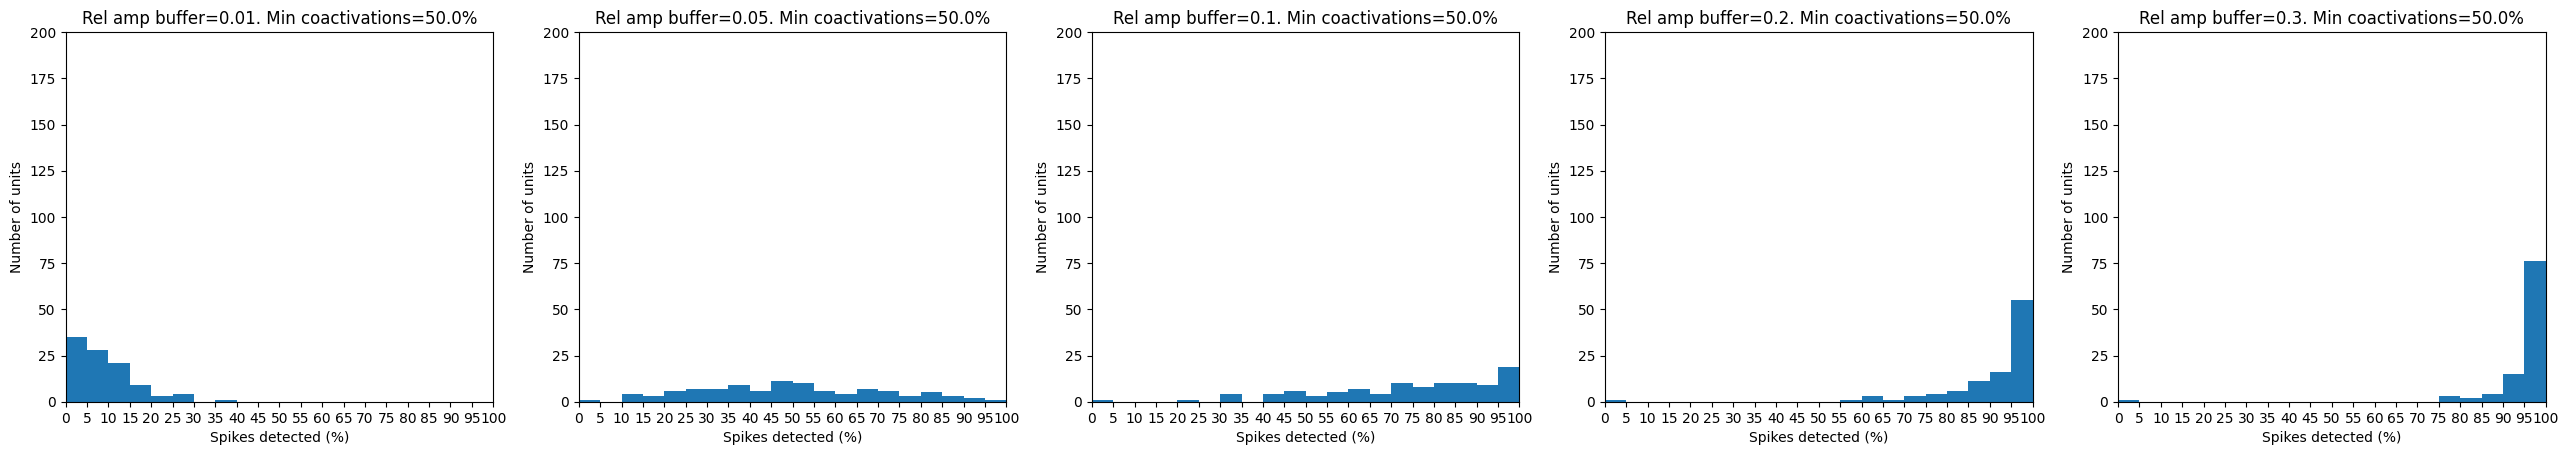

100%|██████████| 5/5 [00:00<00:00, 13.43it/s]


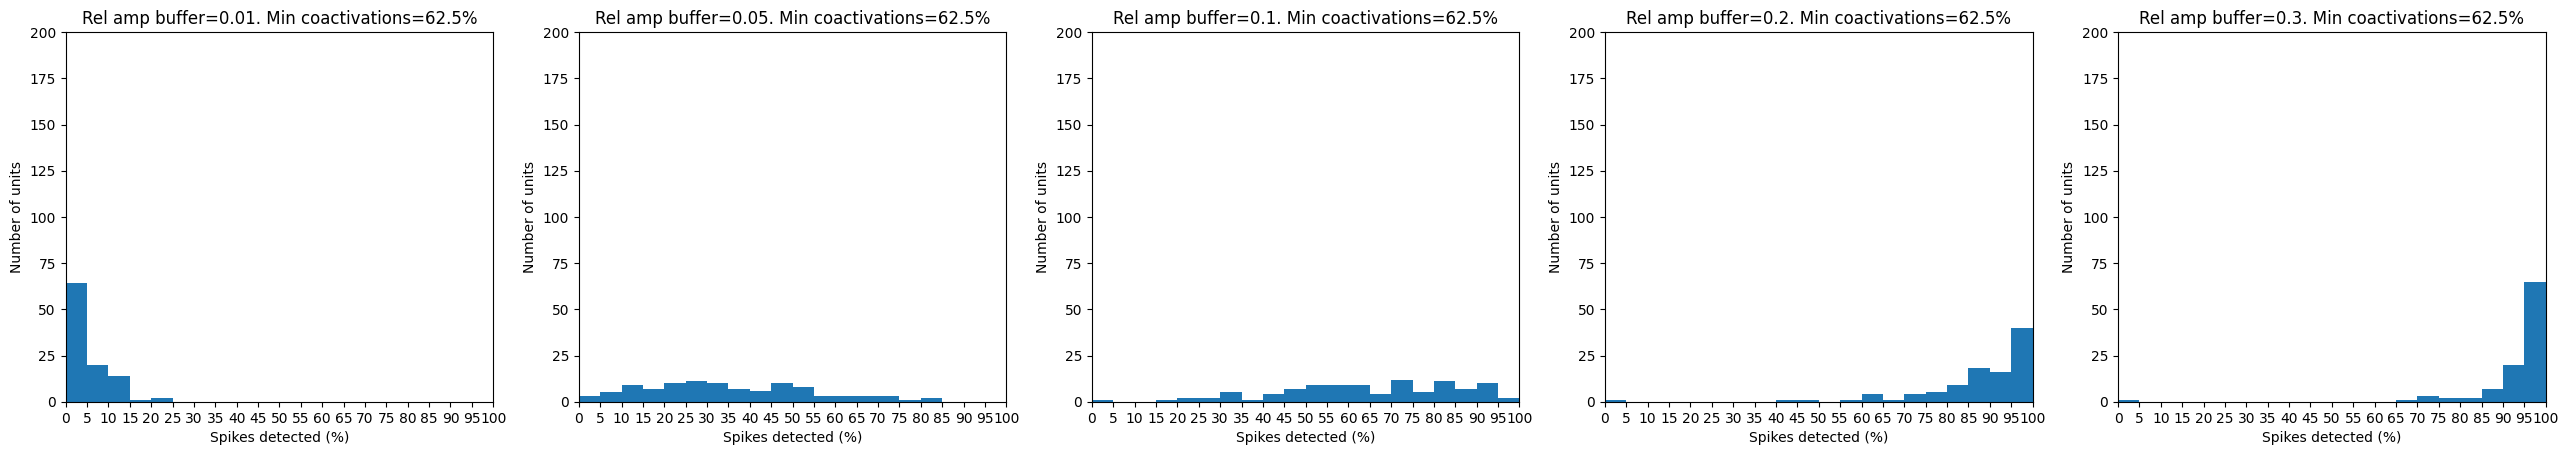

100%|██████████| 5/5 [00:00<00:00, 35.71it/s]


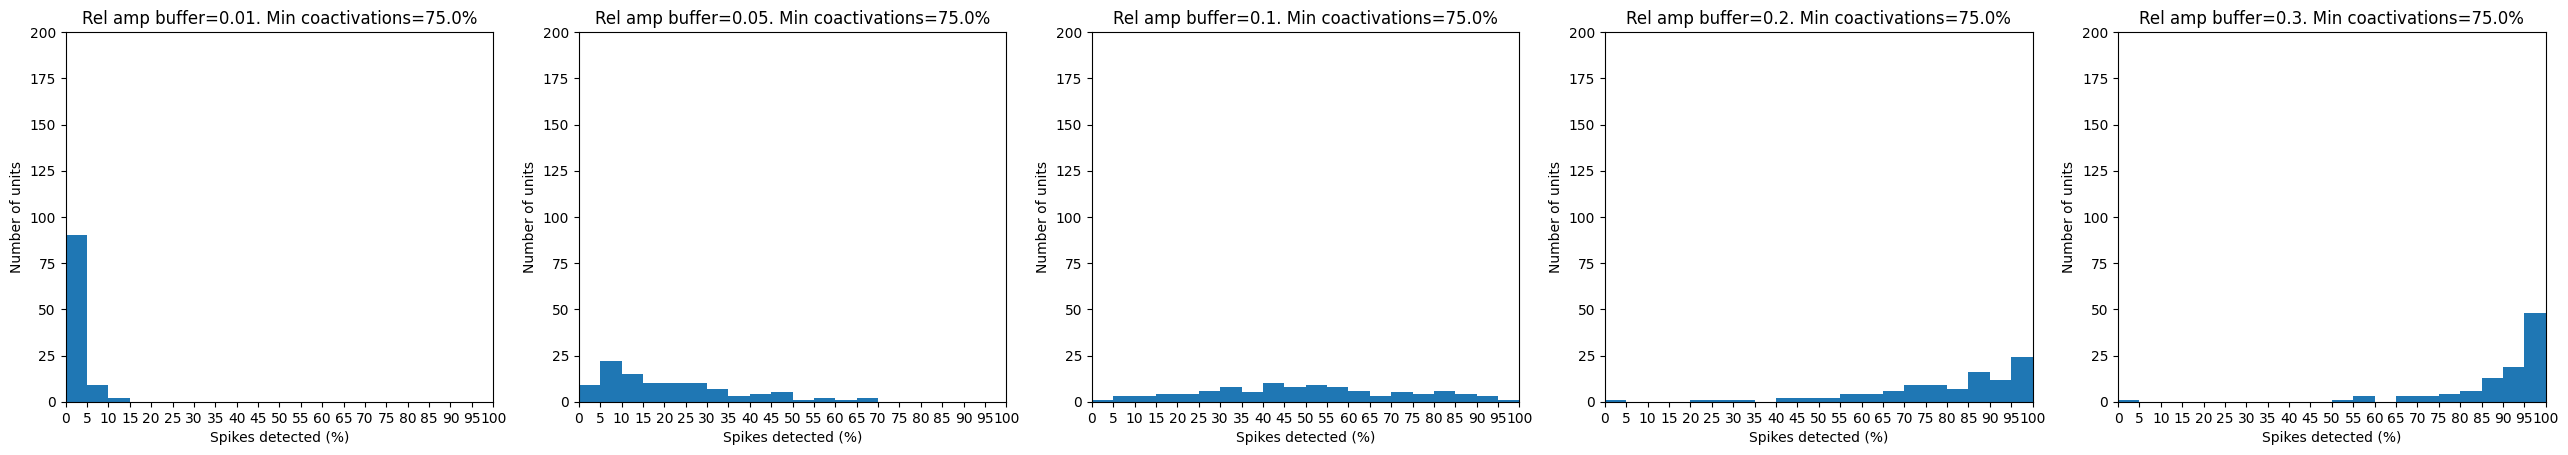

In [32]:
REL_AMP_BUFFERS = [0.01, 0.05, 0.1, 0.2, 0.3] # , 0.1, 0.2, 0.3
MIN_COCC = [0.5, 0.625, 0.75]
##

for min_cocc in MIN_COCC:
    fig, axes = plt.subplots(1, len(REL_AMP_BUFFERS), figsize=(6.4*len(REL_AMP_BUFFERS), 4.8))
    axes = np.atleast_1d(axes)

    # Loop through different paramaters
    for col, rel_amp_buffer in tqdm(enumerate(REL_AMP_BUFFERS), total=len(REL_AMP_BUFFERS)):
        # Create plot
        p_spikes = []
        for unit in ks_units:
            if unit.elecs.size < 2:
                continue
        
            if isinstance(min_cocc, float):
                min_cocc_unit = max(2, min_cocc * unit.elecs.size)
            else:
                min_cocc_unit = min_cocc
                
            rel_amps = unit.spike_matrix[1] / unit.spike_matrix[1, :, 0][:, None]
            temps_rel_amps = unit.temps_amps / unit.temps_amps[0]
            rel_amps_diff = np.abs(rel_amps - temps_rel_amps)
            num_matches = np.sum(rel_amps_diff <= rel_amp_buffer, axis=1)
            num_detections = np.sum(num_matches >= min_cocc_unit)
            p_spikes.append(num_detections / rel_amps.shape[0] * 100)
                    
        plot.hist(p_spikes, bins=range(0, 101, 5), axis=axes[col])

        if isinstance(min_cocc, float):
            min_cocc_str = str(min_cocc * 100)+"%"
        else:
            min_cocc_str = str(min_cocc)
        
        plt.title(f"Rel amp buffer={rel_amp_buffer}. Min coactivations={min_cocc_str}")

        plt.xlabel("Spikes detected (%)")
        # plt.xticks(range(0, 101, 10), [f"{p}%" for p in range(0, 101, 10)])
        plt.xticks(range(0, 101, 5), [f"{p}" for p in range(0, 101, 5)])
        plt.xlim(0, 100)

        plt.ylabel("Number of units")
        plt.ylim(0, 200)
    
    plt.show()

## Latencies and relative amplitude

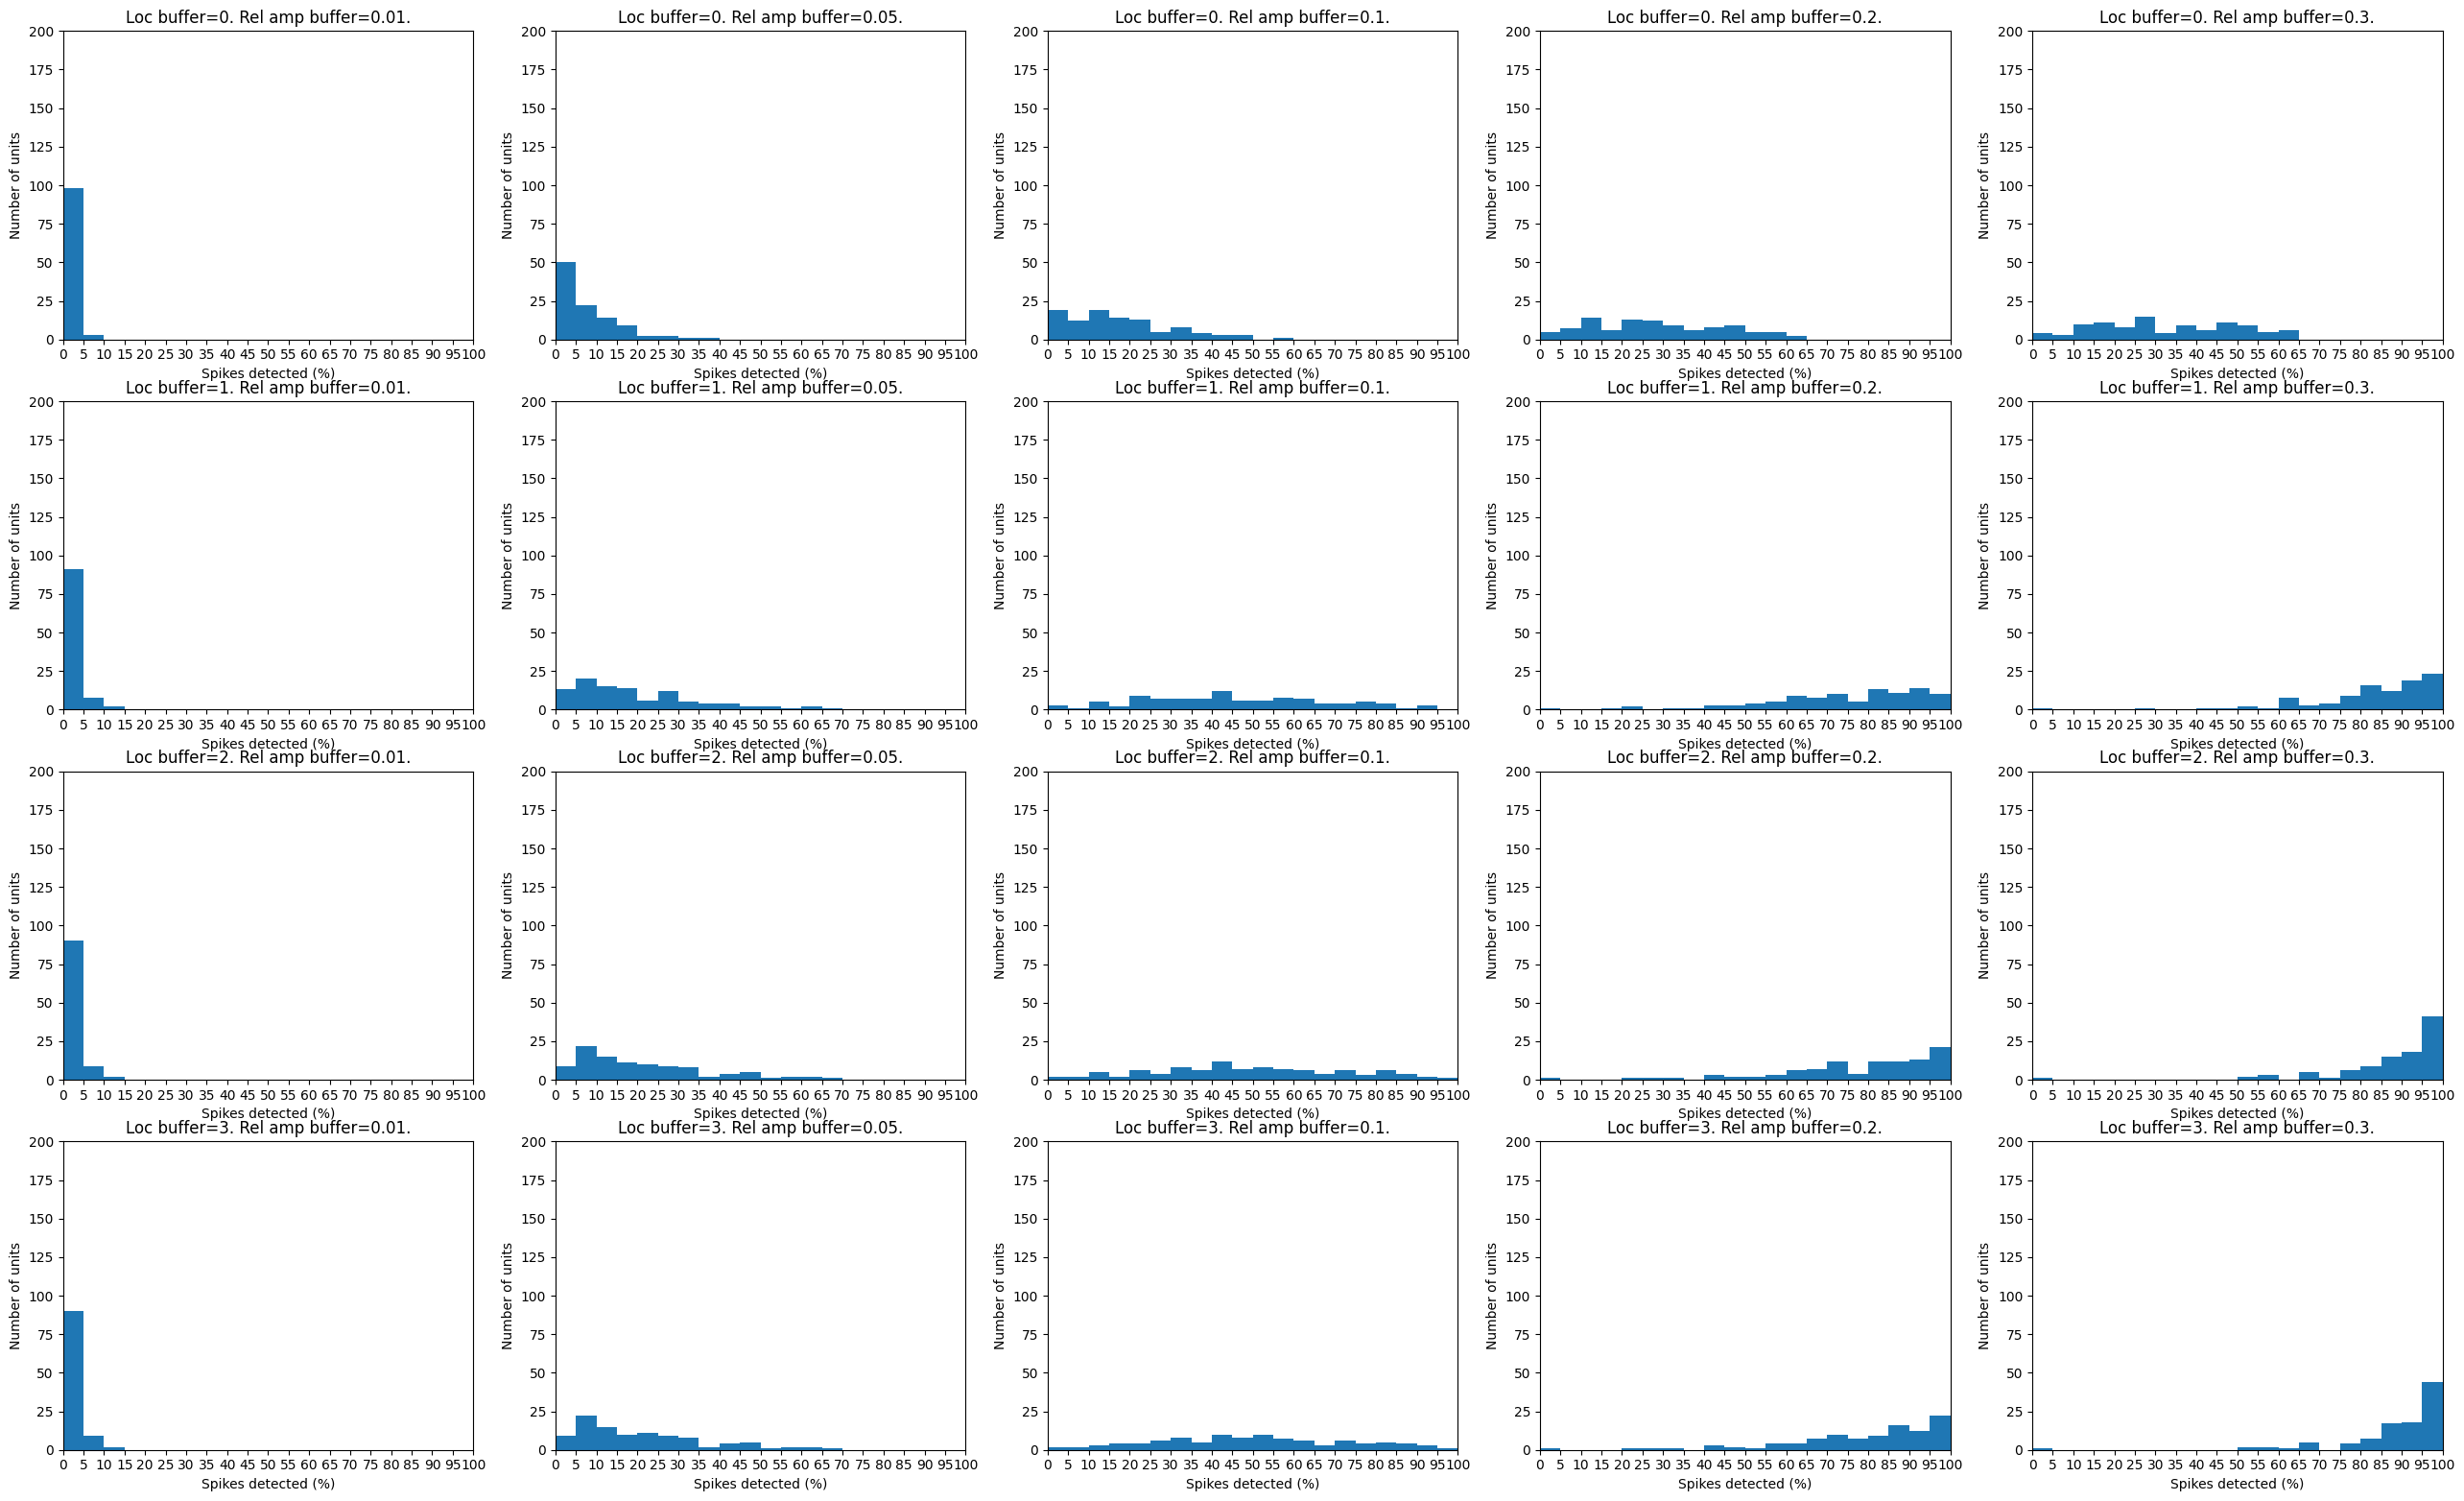

In [33]:
LOC_BUFFERS = [0, 1, 2, 3]
REL_AMP_BUFFERS = [0.01, 0.05, 0.1, 0.2, 0.3] # , 0.1, 0.2, 0.3

MIN_COCC = 0.75
##

fig, axes = plt.subplots(len(LOC_BUFFERS), len(REL_AMP_BUFFERS), figsize=(6.4*len(REL_AMP_BUFFERS), 4.8*len(LOC_BUFFERS)))
axes = np.atleast_2d(axes)

for row, loc_buffer in enumerate(LOC_BUFFERS):
    # Loop through different paramaters
    for col, rel_amp_buffer in enumerate(REL_AMP_BUFFERS):
        # Create plot
        p_spikes = []
        for unit in ks_units:
            if unit.elecs.size < 2:
                continue
            
            if isinstance(MIN_COCC, float):
                min_cocc_unit = max(2, MIN_COCC * unit.elecs.size)
            else:
                min_cocc_unit = MIN_COCC
        
            latencies = unit.spike_matrix[0]
            latencies_diff = np.abs(latencies - unit.temps_latencies)
            latencies_match = latencies_diff <= loc_buffer
            
            rel_amps = unit.spike_matrix[1] / unit.spike_matrix[1, :, 0][:, None]
            temps_rel_amps = unit.temps_amps / unit.temps_amps[0]
            rel_amps_diff = np.abs(rel_amps - temps_rel_amps)
            rel_amps_match = rel_amps_diff <= rel_amp_buffer
            
            both_match = latencies_match & rel_amps_match
            num_matches = np.sum(both_match, axis=1)            

            num_detections = np.sum(num_matches >= min_cocc_unit)
            p_spikes.append(num_detections / rel_amps.shape[0] * 100)
                    
        plot.hist(p_spikes, bins=range(0, 101, 5), axis=axes[row, col])
        
        plt.title(f"Loc buffer={loc_buffer}. Rel amp buffer={rel_amp_buffer}.")

        plt.xlabel("Spikes detected (%)")
        # plt.xticks(range(0, 101, 10), [f"{p}%" for p in range(0, 101, 10)])
        plt.xticks(range(0, 101, 5), [f"{p}" for p in range(0, 101, 5)])
        plt.xlim(0, 100)

        plt.ylabel("Number of units")
        plt.ylim(0, 200)
    
plt.show()